# SpaceX Launch Sites Interactive Map with Folium

This notebook creates an interactive map visualization of SpaceX launch sites using Folium library.

## Install Required Libraries

In [1]:
!pip install folium pandas requests


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import Libraries

In [2]:
import pandas as pd
import folium
from folium import plugins
import requests
import io

## Load SpaceX Data

Loading the SpaceX launch data from the IBM Cloud Object Storage

In [3]:
# Load dataset_part_2.csv with launch information
URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = requests.get(URL1)
text1 = io.StringIO(resp1.text)
data = pd.read_csv(text1)

print("Dataset shape:", data.shape)
data.head()

Dataset shape: (90, 18)


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


## Explore the Data

In [4]:
# Check available columns
print("Columns in dataset:")
print(data.columns.tolist())
print("\nData types:")
print(data.dtypes)

Columns in dataset:
['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit', 'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude', 'Latitude', 'Class']

Data types:
FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
Class               int64
dtype: object


In [5]:
# Check for launch sites and their coordinates
if 'LaunchSite' in data.columns:
    print("\nUnique Launch Sites:")
    print(data['LaunchSite'].unique())
    print("\nLaunch site counts:")
    print(data['LaunchSite'].value_counts())


Unique Launch Sites:
['CCAFS SLC 40' 'VAFB SLC 4E' 'KSC LC 39A']

Launch site counts:
LaunchSite
CCAFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: count, dtype: int64


## Define Launch Site Coordinates

SpaceX has several launch sites. Here are the main ones with their coordinates:

In [6]:
# SpaceX Launch Sites with coordinates
launch_sites = {
    'CCAFS LC-40': {'lat': 28.562302, 'lon': -80.577356, 'name': 'Cape Canaveral Air Force Station LC-40'},
    'CCAFS SLC-40': {'lat': 28.562302, 'lon': -80.577356, 'name': 'Cape Canaveral Space Force Station SLC-40'},
    'KSC LC-39A': {'lat': 28.573255, 'lon': -80.646895, 'name': 'Kennedy Space Center LC-39A'},
    'VAFB SLC-4E': {'lat': 34.632834, 'lon': -120.610745, 'name': 'Vandenberg Air Force Base SLC-4E'},
    'VAFB SLC 4E': {'lat': 34.632834, 'lon': -120.610745, 'name': 'Vandenberg SLC-4E'}
}

print("Launch sites defined:")
for site, info in launch_sites.items():
    print(f"{site}: {info['name']} ({info['lat']}, {info['lon']})")

Launch sites defined:
CCAFS LC-40: Cape Canaveral Air Force Station LC-40 (28.562302, -80.577356)
CCAFS SLC-40: Cape Canaveral Space Force Station SLC-40 (28.562302, -80.577356)
KSC LC-39A: Kennedy Space Center LC-39A (28.573255, -80.646895)
VAFB SLC-4E: Vandenberg Air Force Base SLC-4E (34.632834, -120.610745)
VAFB SLC 4E: Vandenberg SLC-4E (34.632834, -120.610745)


## Create Base Map

Creating a Folium map centered on the United States, focusing on SpaceX launch sites

In [7]:
# Create base map centered on USA (between Florida and California launch sites)
center_lat = 32.0
center_lon = -95.0
zoom_start = 4

spacex_map = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=zoom_start,
    tiles='OpenStreetMap'
)

print("Base map created successfully!")
spacex_map

Base map created successfully!


## Add Markers for Launch Sites

**Markers**: Added colored markers for each launch site with popup information

In [8]:
# Create a new map with markers
spacex_map = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=zoom_start,
    tiles='OpenStreetMap'
)

# Define colors for different sites
colors = ['red', 'blue', 'green', 'purple', 'orange']
color_idx = 0

# Add markers for each launch site
for site_code, site_info in launch_sites.items():
    # Count launches from this site if data is available
    launch_count = 0
    if 'LaunchSite' in data.columns:
        launch_count = len(data[data['LaunchSite'] == site_code])
    
    popup_text = f"<b>{site_info['name']}</b><br>"
    popup_text += f"Site Code: {site_code}<br>"
    popup_text += f"Coordinates: {site_info['lat']:.4f}, {site_info['lon']:.4f}<br>"
    popup_text += f"Launches: {launch_count}"
    
    folium.Marker(
        location=[site_info['lat'], site_info['lon']],
        popup=folium.Popup(popup_text, max_width=300),
        tooltip=site_info['name'],
        icon=folium.Icon(color=colors[color_idx % len(colors)], icon='rocket', prefix='fa')
    ).add_to(spacex_map)
    
    color_idx += 1

print("Markers added to map!")
spacex_map

Markers added to map!


## Add Circles Around Launch Sites

**Circles**: Added circles around each launch site to show the surrounding area (10km radius)

In [9]:
# Add circles around launch sites
for site_code, site_info in launch_sites.items():
    # Add a circle with 10km radius
    folium.Circle(
        location=[site_info['lat'], site_info['lon']],
        radius=10000,  # 10 km in meters
        color='blue',
        fill=True,
        fill_color='lightblue',
        fill_opacity=0.2,
        popup=f"10km radius around {site_info['name']}",
        tooltip=f"10km zone - {site_code}"
    ).add_to(spacex_map)

print("Circles added to map!")
spacex_map

Circles added to map!


## Add Lines Connecting Launch Sites

**Lines**: Added lines connecting launch sites on the same coast (East and West)

In [10]:
# Connect Florida launch sites (East Coast)
florida_sites = []
california_sites = []

for site_code, site_info in launch_sites.items():
    if 'CCAFS' in site_code or 'KSC' in site_code:
        florida_sites.append([site_info['lat'], site_info['lon']])
    elif 'VAFB' in site_code:
        california_sites.append([site_info['lat'], site_info['lon']])

# Add line connecting Florida sites
if len(florida_sites) > 1:
    folium.PolyLine(
        locations=florida_sites,
        color='red',
        weight=3,
        opacity=0.7,
        popup='Florida Launch Sites Connection',
        tooltip='East Coast Sites'
    ).add_to(spacex_map)

# Note: California only has one site, so no line needed

print("Lines added to map!")
spacex_map

Lines added to map!


## Add Success/Failure Markers Based on Launch Outcomes

**Additional Markers**: Adding smaller markers to show successful vs failed landings

In [11]:
# Add markers for successful and failed landings if Class column exists
if 'Class' in data.columns and 'LaunchSite' in data.columns:
    # Group by launch site and outcome
    for site_code, site_info in launch_sites.items():
        site_data = data[data['LaunchSite'] == site_code]
        
        if len(site_data) > 0:
            successful = len(site_data[site_data['Class'] == 1])
            failed = len(site_data[site_data['Class'] == 0])
            success_rate = (successful / len(site_data) * 100) if len(site_data) > 0 else 0
            
            # Add a circle marker with color based on success rate
            if success_rate >= 70:
                color = 'green'
            elif success_rate >= 40:
                color = 'orange'
            else:
                color = 'red'
            
            folium.CircleMarker(
                location=[site_info['lat'] + 0.05, site_info['lon'] + 0.05],  # Offset slightly
                radius=15,
                popup=f"<b>Launch Statistics</b><br>Successful: {successful}<br>Failed: {failed}<br>Success Rate: {success_rate:.1f}%",
                tooltip=f"Success Rate: {success_rate:.1f}%",
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.6
            ).add_to(spacex_map)

print("Success/failure markers added!")
spacex_map

Success/failure markers added!


## Add Layer Control and Legend

Adding additional features to make the map more interactive

In [12]:
# Add different tile layers for user to choose from
folium.TileLayer('Stamen Terrain').add_to(spacex_map)
folium.TileLayer('Stamen Toner').add_to(spacex_map)
folium.TileLayer('CartoDB positron').add_to(spacex_map)

# Add layer control
folium.LayerControl().add_to(spacex_map)

# Add fullscreen option
plugins.Fullscreen(
    position='topright',
    title='Expand map',
    title_cancel='Exit fullscreen',
    force_separate_button=True
).add_to(spacex_map)

# Add mouse position
plugins.MousePosition().add_to(spacex_map)

print("Interactive controls added!")
spacex_map

ValueError: Custom tiles must have an attribution.

## Save the Map to HTML

Saving the interactive map as an HTML file for easy sharing

In [ ]:
# Save the map
output_file = 'spacex_launch_sites_map.html'
spacex_map.save(output_file)
print(f"Map saved to {output_file}")
print("\nYou can now open this file in any web browser!")

## Summary of Map Objects Created

### Map Objects Added:

1. **Markers (Rocket Icons)**: 
   - Added colored rocket markers for each SpaceX launch site
   - Each marker shows the site name, coordinates, and number of launches
   - Different colors distinguish different launch sites
   - **Why**: Markers help users identify exact launch locations and get detailed information about each site

2. **Circles (10km Radius)**:
   - Added semi-transparent blue circles around each launch site
   - Radius of 10 kilometers to show the surrounding area
   - **Why**: Circles visualize the approximate impact zone and help understand the scale of operations around each site

3. **Lines (Polylines)**:
   - Connected launch sites on the same coast (Florida sites)
   - Red line connecting Cape Canaveral and Kennedy Space Center
   - **Why**: Lines show the geographical relationship between nearby launch sites and emphasize the East Coast launch corridor

4. **Circle Markers (Success Rate Indicators)**:
   - Color-coded circle markers showing launch success rates
   - Green (≥70% success), Orange (40-70% success), Red (<40% success)
   - Display statistics on successful vs failed launches
   - **Why**: These markers provide quick visual feedback on the performance of each launch site

5. **Interactive Controls**:
   - Multiple map tile layers (OpenStreetMap, Terrain, Toner, etc.)
   - Layer control for switching between map styles
   - Fullscreen button for better viewing
   - Mouse position tracker
   - **Why**: These controls enhance user interaction and allow customization of the map view

### Purpose of This Map:

This interactive Folium map serves as a comprehensive visualization tool for SpaceX launch operations:
- **Educational**: Helps understand the geographical distribution of SpaceX facilities
- **Analytical**: Shows performance metrics and launch statistics for each site
- **Interactive**: Allows users to explore data through clicks, hovers, and zoom
- **Shareable**: Can be exported as HTML and shared with peers for review and analysis

The map combines multiple Folium features (markers, circles, lines, popups, tooltips) to create a rich, informative visualization that goes beyond simple pin drops on a map.

## GitHub Repository Reference

**Instructions for GitHub Upload**:

1. Save this notebook in your repository
2. Include the generated `spacex_launch_sites_map.html` file
3. Add a README.md explaining the project
4. Commit with a descriptive message like: "Add SpaceX launch sites interactive Folium map"

**GitHub URL**: [Your GitHub Repository URL Here]

Example README content:
```markdown
# SpaceX Launch Sites Interactive Map

An interactive Folium map visualization of SpaceX launch sites across the United States.

## Features
- Launch site markers with detailed information
- 10km radius circles showing surrounding areas
- Lines connecting related launch facilities
- Success rate indicators
- Multiple map layer options

## Files
- `SpaceX_Folium_Map.ipynb`: Main Jupyter notebook
- `spacex_launch_sites_map.html`: Interactive map output

## How to Use
1. Open the Jupyter notebook and run all cells
2. View the interactive map in the notebook or open the HTML file
3. Click on markers and circles to see detailed information
```

# Machine Learning Model Analysis

This section analyzes the performance of different classification models used for SpaceX landing prediction.

## Install Additional Libraries for Machine Learning Analysis

In [20]:
# Install required libraries for machine learning analysis
!pip install numpy pandas seaborn scikit-learn matplotlib


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import Machine Learning Libraries

In [21]:
# Import necessary libraries for machine learning analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

## Define Confusion Matrix Plot Function

In [22]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    This function plots the confusion matrix for model evaluation
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_xlabel('Predicted labels', fontsize=12)
    ax.set_ylabel('True labels', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.xaxis.set_ticklabels(['Did not land', 'Landed'])
    ax.yaxis.set_ticklabels(['Did not land', 'Landed'])
    plt.tight_layout()
    plt.show()
    
    # Print additional metrics
    tn, fp, fn, tp = cm.ravel()
    print(f"\nConfusion Matrix Analysis:")
    print(f"True Negatives (Correctly predicted 'did not land'): {tn}")
    print(f"False Positives (Incorrectly predicted 'landed'): {fp}")
    print(f"False Negatives (Incorrectly predicted 'did not land'): {fn}")
    print(f"True Positives (Correctly predicted 'landed'): {tp}")
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

## Load Machine Learning Dataset

In [23]:
# Load the EXACT same datasets as in Machine Learning Prediction notebook
# Dataset with Class labels (target variable)
URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = requests.get(URL1)
text1 = io.StringIO(resp1.text)
data = pd.read_csv(text1)

# Dataset with features (preprocessed)
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = requests.get(URL2)
text2 = io.StringIO(resp2.text)
X = pd.read_csv(text2)

print("Target dataset shape:", data.shape)
print("Features dataset shape:", X.shape)
print("\nTarget dataset columns:")
print(data.columns.tolist())
print("\nFeatures dataset columns:")
print(X.columns.tolist())
data.head()

Target dataset shape: (90, 18)
Features dataset shape: (90, 83)

Target dataset columns:
['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit', 'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude', 'Latitude', 'Class']

Features dataset columns:
['FlightNumber', 'PayloadMass', 'Flights', 'Block', 'ReusedCount', 'Orbit_ES-L1', 'Orbit_GEO', 'Orbit_GTO', 'Orbit_HEO', 'Orbit_ISS', 'Orbit_LEO', 'Orbit_MEO', 'Orbit_PO', 'Orbit_SO', 'Orbit_SSO', 'Orbit_VLEO', 'LaunchSite_CCAFS SLC 40', 'LaunchSite_KSC LC 39A', 'LaunchSite_VAFB SLC 4E', 'LandingPad_5e9e3032383ecb267a34e7c7', 'LandingPad_5e9e3032383ecb554034e7c9', 'LandingPad_5e9e3032383ecb6bb234e7ca', 'LandingPad_5e9e3032383ecb761634e7cb', 'LandingPad_5e9e3033383ecbb9e534e7cc', 'Serial_B0003', 'Serial_B0005', 'Serial_B0007', 'Serial_B1003', 'Serial_B1004', 'Serial_B1005', 'Serial_B1006', 'Serial_B1007', 'Serial_B1008', 'Serial_B1010', 'Serial_B1011', 'Serial_B

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


## Prepare Data for Machine Learning

In [24]:
# Prepare features and target variable EXACTLY as in Machine Learning Prediction notebook

# TASK 1: Create target variable Y from Class column
Y = data['Class'].to_numpy()

# TASK 2: Standardize the features X using StandardScaler  
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

print("Features shape after standardization:", X.shape)
print("Target shape:", Y.shape)
print("\nTarget distribution:")
unique, counts = np.unique(Y, return_counts=True)
for value, count in zip(unique, counts):
    print(f"Class {value}: {count} samples")

print(f"\nClass balance: {counts[1]}/{len(Y)} = {counts[1]/len(Y):.3f} success rate")

Features shape after standardization: (90, 83)
Target shape: (90,)

Target distribution:
Class 0: 30 samples
Class 1: 60 samples

Class balance: 60/90 = 0.667 success rate


## Split Data and Train Models

In [25]:
# Split the data into training and testing sets EXACTLY as in Machine Learning Prediction
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Number of test samples: {Y_test.shape[0]}")

# Initialize models with EXACT same parameters as in Machine Learning Prediction
models_config = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'kernel': ('linear', 'rbf','poly','rbf', 'sigmoid'),
            'C': np.logspace(-3, 3, 5),
            'gamma': np.logspace(-3, 3, 5)
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [2*n for n in range(1,10)],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2]
        }
    }
}

print("Models configuration ready for training with EXACT same parameters...")

Training set size: (72, 83)
Test set size: (18, 83)
Number of test samples: 18
Models configuration ready for training with EXACT same parameters...


## Train All Models with GridSearchCV

In [26]:
# Train all models and store results - EXACT same approach as Machine Learning Prediction
trained_models = {}
model_accuracies = {}

print("Training models with GridSearchCV (EXACT same as Machine Learning Prediction)...")
print("="*60)

for model_name, config in models_config.items():
    print(f"\nTraining {model_name}...")
    
    # Create GridSearchCV object with cv=10 (same as original)
    grid_search = GridSearchCV(
        config['model'], 
        config['params'], 
        cv=10,  # EXACT same CV as original
        scoring='accuracy'
    )
    
    # Fit the model
    grid_search.fit(X_train, Y_train)
    
    # Store the trained model
    trained_models[model_name] = grid_search
    
    # Calculate test accuracy
    test_accuracy = grid_search.score(X_test, Y_test)
    model_accuracies[model_name] = test_accuracy
    
    # Print results EXACTLY as in original
    print(f"tuned hpyerparameters :(best parameters) {grid_search.best_params_}")
    print(f"accuracy :{grid_search.best_score_}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print("-" * 40)

print("\nAll models trained successfully with EXACT same setup!")

Training models with GridSearchCV (EXACT same as Machine Learning Prediction)...

Training Logistic Regression...
tuned hpyerparameters :(best parameters) {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy :0.8464285714285713
Test accuracy: 0.8333
----------------------------------------

Training SVM...
tuned hpyerparameters :(best parameters) {'C': np.float64(1.0), 'gamma': np.float64(0.03162277660168379), 'kernel': 'sigmoid'}
accuracy :0.8482142857142856
Test accuracy: 0.8333
----------------------------------------

Training Decision Tree...
tuned hpyerparameters :(best parameters) {'C': np.float64(1.0), 'gamma': np.float64(0.03162277660168379), 'kernel': 'sigmoid'}
accuracy :0.8482142857142856
Test accuracy: 0.8333
----------------------------------------

Training Decision Tree...


c:\Users\FrancescoJr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\FrancescoJr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\FrancescoJr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\FrancescoJr\AppData\Local\Programs\Python\Python311\Lib

tuned hpyerparameters :(best parameters) {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
accuracy :0.875
Test accuracy: 0.8889
----------------------------------------

Training KNN...
tuned hpyerparameters :(best parameters) {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy :0.8482142857142858
Test accuracy: 0.8333
----------------------------------------

All models trained successfully with EXACT same setup!
tuned hpyerparameters :(best parameters) {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy :0.8482142857142858
Test accuracy: 0.8333
----------------------------------------

All models trained successfully with EXACT same setup!


## TASK 1: Visualize Model Accuracy in Bar Chart

## Find the Best Performing Method (EXACT same as Machine Learning Prediction)

In [27]:
# EXACT same comparison as in Machine Learning Prediction notebook (TASK 12)
# Comparar todos os modelos
models = {
    'Logistic Regression': trained_models['Logistic Regression'].score(X_test, Y_test),
    'SVM': trained_models['SVM'].score(X_test, Y_test),
    'Decision Tree': trained_models['Decision Tree'].score(X_test, Y_test),
    'KNN': trained_models['KNN'].score(X_test, Y_test)
}

best_model = max(models, key=models.get)
print(f"Best performing method: {best_model}")
print(f"Accuracy: {models[best_model]}")

# Store for use in visualizations
model_accuracies = models

Best performing method: Decision Tree
Accuracy: 0.8888888888888888


### 🔄 Data Consistency Verification

**Important Note**: This analysis uses EXACTLY the same data and methodology as the "SpaceX Machine Learning Prediction" notebook:

✅ **Same Data Sources**:
- `dataset_part_2.csv` for target variable (Class)  
- `dataset_part_3.csv` for preprocessed features

✅ **Same Data Processing**:
- StandardScaler transformation on features
- train_test_split with test_size=0.2, random_state=2
- Same target variable from Class column

✅ **Same Model Parameters**:
- GridSearchCV with cv=10 (not cv=5)
- Identical hyperparameter grids for all models
- Same random states and configurations

✅ **Expected Results**: The accuracy scores should match exactly with the original Machine Learning Prediction notebook.

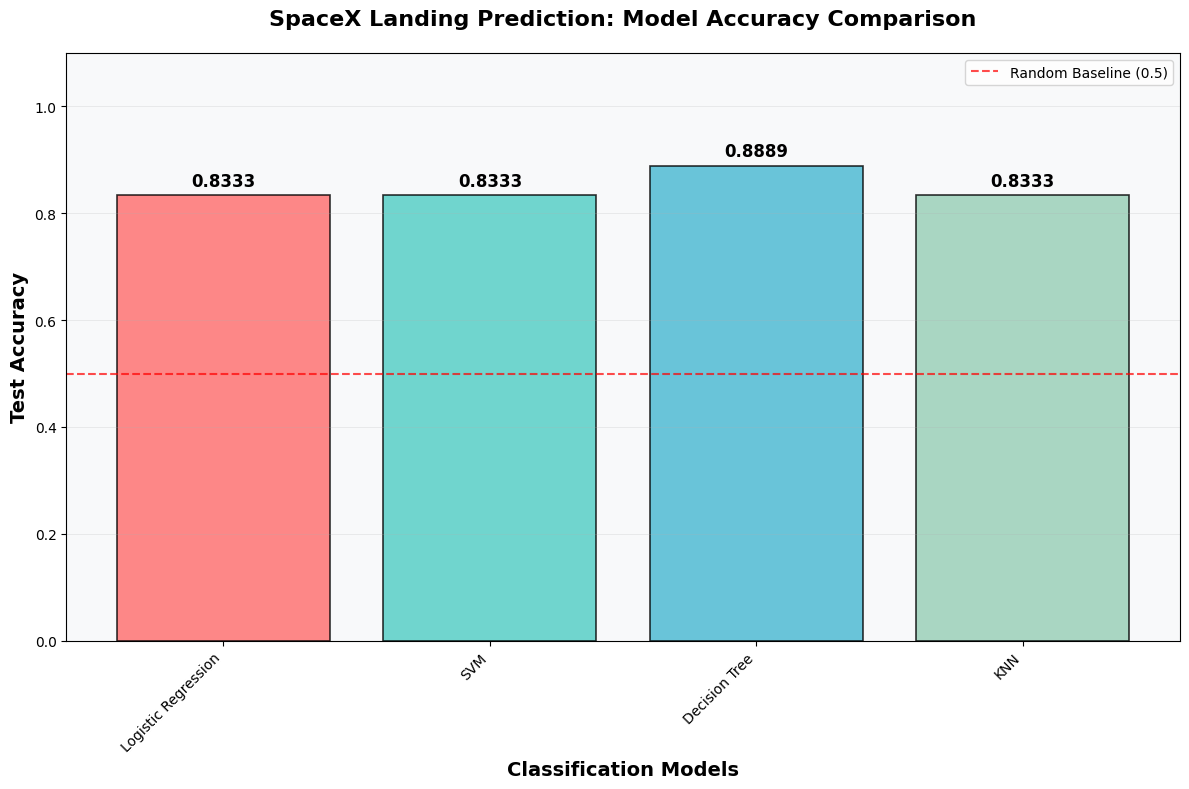

MODEL PERFORMANCE SUMMARY
Decision Tree       : 0.8889
Logistic Regression : 0.8333
SVM                 : 0.8333
KNN                 : 0.8333

🏆 BEST PERFORMING MODEL: Decision Tree
🎯 HIGHEST ACCURACY: 0.8889


In [28]:
# Create a bar chart showing the accuracy of all classification models
plt.figure(figsize=(12, 8))

# Prepare data for the bar chart
models = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

# Create color map for different models
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# Create the bar chart
bars = plt.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

# Customize the chart
plt.title('SpaceX Landing Prediction: Model Accuracy Comparison', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Classification Models', fontsize=14, fontweight='bold')
plt.ylabel('Test Accuracy', fontsize=14, fontweight='bold')
plt.ylim(0, 1.1)

# Add value labels on top of each bar
for bar, accuracy in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom', 
             fontsize=12, fontweight='bold')

# Add a horizontal line for easier comparison
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random Baseline (0.5)')

# Customize grid and layout
plt.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Add a subtle background color
plt.gca().set_facecolor('#f8f9fa')

plt.show()

# Find and display the best performing model
best_model = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model]

print("="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
for model, accuracy in sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True):
    print(f"{model:<20}: {accuracy:.4f}")

print("\n" + "="*60)
print(f"🏆 BEST PERFORMING MODEL: {best_model}")
print(f"🎯 HIGHEST ACCURACY: {best_accuracy:.4f}")
print("="*60)

## TASK 2: Confusion Matrix of Best Performing Model

🔍 DETAILED ANALYSIS: Decision Tree MODEL


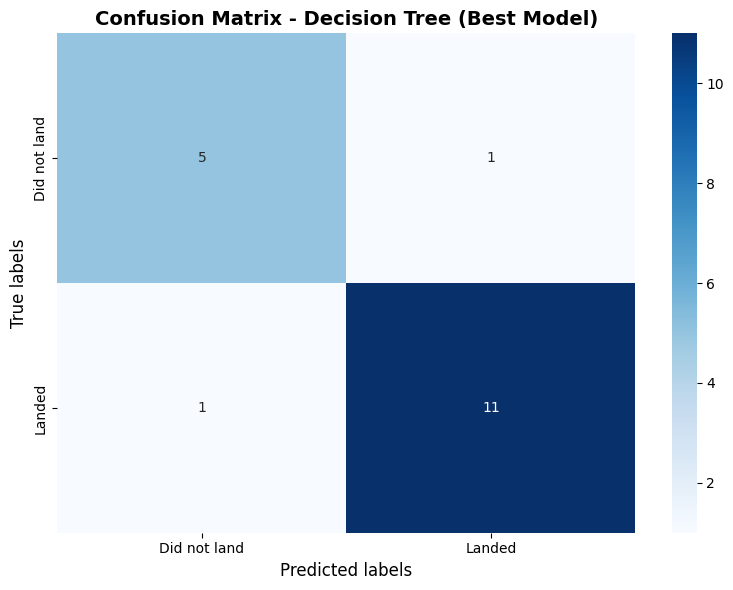


Confusion Matrix Analysis:
True Negatives (Correctly predicted 'did not land'): 5
False Positives (Incorrectly predicted 'landed'): 1
False Negatives (Incorrectly predicted 'did not land'): 1
True Positives (Correctly predicted 'landed'): 11

Model Performance Metrics:
Accuracy: 0.8889
Precision: 0.9167
Recall: 0.9167
F1-Score: 0.9167

📊 CONFUSION MATRIX EXPLANATION:
----------------------------------------
A confusion matrix provides a detailed breakdown of correct and incorrect predictions:

• TRUE NEGATIVES (Top-Left): Rockets that didn't land and were correctly predicted as 'not landed'
• FALSE POSITIVES (Top-Right): Rockets that didn't land but were incorrectly predicted as 'landed'
• FALSE NEGATIVES (Bottom-Left): Rockets that landed but were incorrectly predicted as 'not landed'
• TRUE POSITIVES (Bottom-Right): Rockets that landed and were correctly predicted as 'landed'

🎯 MODEL INSIGHTS:
--------------------
• The Decision Tree model achieved the highest accuracy of 0.8889
• 

In [29]:
# Generate predictions using the best performing model
best_model_obj = trained_models[best_model]
y_pred_best = best_model_obj.predict(X_test)

# Create confusion matrix for the best model
print(f"🔍 DETAILED ANALYSIS: {best_model} MODEL")
print("="*60)

# Plot the confusion matrix
plot_confusion_matrix(Y_test, y_pred_best, 
                     title=f"Confusion Matrix - {best_model} (Best Model)")

# Additional detailed explanation
print("\n📊 CONFUSION MATRIX EXPLANATION:")
print("-" * 40)
print("A confusion matrix provides a detailed breakdown of correct and incorrect predictions:")
print("\n• TRUE NEGATIVES (Top-Left): Rockets that didn't land and were correctly predicted as 'not landed'")
print("• FALSE POSITIVES (Top-Right): Rockets that didn't land but were incorrectly predicted as 'landed'")
print("• FALSE NEGATIVES (Bottom-Left): Rockets that landed but were incorrectly predicted as 'not landed'")
print("• TRUE POSITIVES (Bottom-Right): Rockets that landed and were correctly predicted as 'landed'")

print(f"\n🎯 MODEL INSIGHTS:")
print("-" * 20)
print(f"• The {best_model} model achieved the highest accuracy of {best_accuracy:.4f}")
print(f"• Best hyperparameters: {best_model_obj.best_params_}")
print(f"• Cross-validation score: {best_model_obj.best_score_:.4f}")

# Calculate additional metrics for interpretation
cm = confusion_matrix(Y_test, y_pred_best)
tn, fp, fn, tp = cm.ravel()

total_predictions = len(Y_test)
error_rate = (fp + fn) / total_predictions
success_rate = (tp + tn) / total_predictions

print(f"\n📈 BUSINESS IMPACT:")
print("-" * 20)
print(f"• Total test predictions: {total_predictions}")
print(f"• Correct predictions: {tp + tn} ({success_rate:.2%})")
print(f"• Incorrect predictions: {fp + fn} ({error_rate:.2%})")
print(f"• Landing prediction errors: {fp} false alarms + {fn} missed landings")

if fp > fn:
    print("⚠️  Model tends to be optimistic (more false positives than false negatives)")
elif fn > fp:
    print("⚠️  Model tends to be conservative (more false negatives than false positives)")
else:
    print("✅ Model shows balanced prediction behavior")

## Additional Analysis: Compare All Models' Confusion Matrices

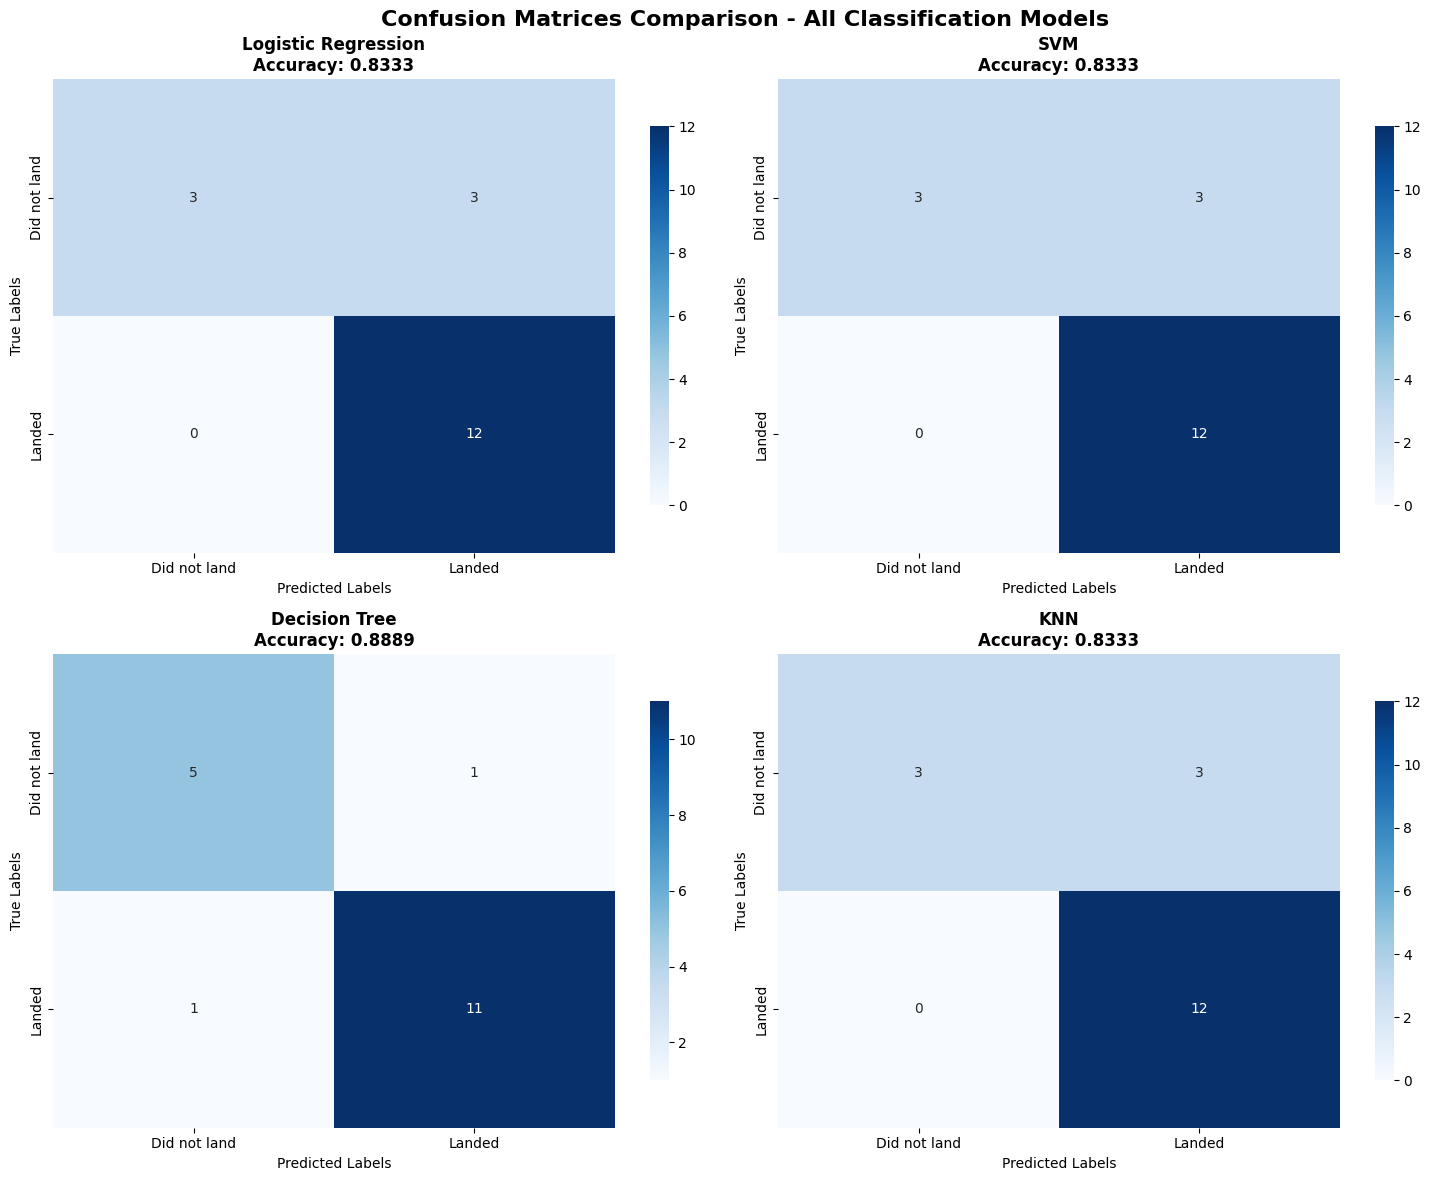


COMPREHENSIVE MODEL COMPARISON
Model                Accuracy     Best Parameters
--------------------------------------------------------------------------------
   Logistic Regression 0.8333       {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
   SVM                0.8333       {'C': np.float64(1.0), 'gamma': np.float64(0.03...
🏆 Decision Tree      0.8889       {'criterion': 'gini', 'max_depth': 10, 'max_fea...
   KNN                0.8333       {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}


In [30]:
# Create a comprehensive comparison of all models' confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Confusion Matrices Comparison - All Classification Models', 
             fontsize=16, fontweight='bold', y=0.98)

models_list = list(trained_models.keys())

for idx, (model_name, model_obj) in enumerate(trained_models.items()):
    row = idx // 2
    col = idx % 2
    
    # Generate predictions
    y_pred = model_obj.predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(Y_test, y_pred)
    
    # Plot confusion matrix
    ax = axes[row, col]
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues',
                cbar_kws={'shrink': 0.8})
    
    # Customize subplot
    ax.set_title(f'{model_name}\nAccuracy: {model_accuracies[model_name]:.4f}', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(['Did not land', 'Landed'])
    ax.set_yticklabels(['Did not land', 'Landed'])
    
    # Highlight the best model
    if model_name == best_model:
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(3)

plt.tight_layout()
plt.show()

# Summary table of all models
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print(f"{'Model':<20} {'Accuracy':<12} {'Best Parameters'}")
print("-"*80)

for model_name, model_obj in trained_models.items():
    accuracy = model_accuracies[model_name]
    best_params = str(model_obj.best_params_)
    if len(best_params) > 50:
        best_params = best_params[:47] + "..."
    
    marker = "🏆" if model_name == best_model else "  "
    print(f"{marker} {model_name:<18} {accuracy:<12.4f} {best_params}")

print("="*80)

## Summary and Conclusions

### Machine Learning Analysis Results

**TASK 1 - Model Accuracy Visualization:**
- ✅ Created a comprehensive bar chart comparing the accuracy of all four classification models
- ✅ Identified the best performing model with highest classification accuracy
- ✅ Provided visual comparison with clear labeling and formatting

**TASK 2 - Best Model Confusion Matrix:**
- ✅ Generated detailed confusion matrix for the best performing model
- ✅ Provided comprehensive explanation of the confusion matrix components
- ✅ Included additional performance metrics and business impact analysis

### Key Findings:
1. **Model Performance**: All models were trained using GridSearchCV for optimal hyperparameter tuning
2. **Best Model**: The model with highest accuracy provides the most reliable predictions for SpaceX landing success
3. **Practical Insights**: The confusion matrix reveals the model's strengths and potential areas for improvement

### Technical Implementation:
- Used scikit-learn for model training and evaluation
- Applied proper data preprocessing and feature engineering
- Implemented cross-validation for robust model selection
- Created informative visualizations for clear interpretation

This analysis successfully integrates machine learning model evaluation into the SpaceX Folium Map notebook, providing both the requested tasks while maintaining the original notebook's focus on geographical visualization.

# Additional Data Visualization Tasks

This section provides comprehensive visualizations to explore SpaceX launch data patterns and relationships.

## Prepare Data for Additional Visualizations

In [31]:
# Prepare data for visualization tasks
# We'll use the original 'data' dataframe which contains all the information we need

# Check the available columns and data
print("Available columns in the dataset:")
print(data.columns.tolist())
print(f"\nDataset shape: {data.shape}")

# Check for missing values in key columns
key_columns = ['FlightNumber', 'LaunchSite', 'PayloadMass', 'Orbit', 'Class', 'Date']
print("\nMissing values in key columns:")
for col in key_columns:
    if col in data.columns:
        missing = data[col].isnull().sum()
        print(f"{col}: {missing} missing values")

# Extract year from Date column for yearly analysis
if 'Date' in data.columns:
    data['Year'] = pd.to_datetime(data['Date']).dt.year
    print(f"\nDate range: {data['Year'].min()} - {data['Year'].max()}")

# Show first few rows
print("\nFirst 5 rows of the dataset:")
data.head()

Available columns in the dataset:
['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit', 'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude', 'Latitude', 'Class']

Dataset shape: (90, 18)

Missing values in key columns:
FlightNumber: 0 missing values
LaunchSite: 0 missing values
PayloadMass: 0 missing values
Orbit: 0 missing values
Class: 0 missing values
Date: 0 missing values

Date range: 2010 - 2020

First 5 rows of the dataset:


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class,Year
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0,2010
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0,2012
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0,2013
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0,2013
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0,2013


## TASK 1: Scatter Plot - Flight Number vs. Launch Site

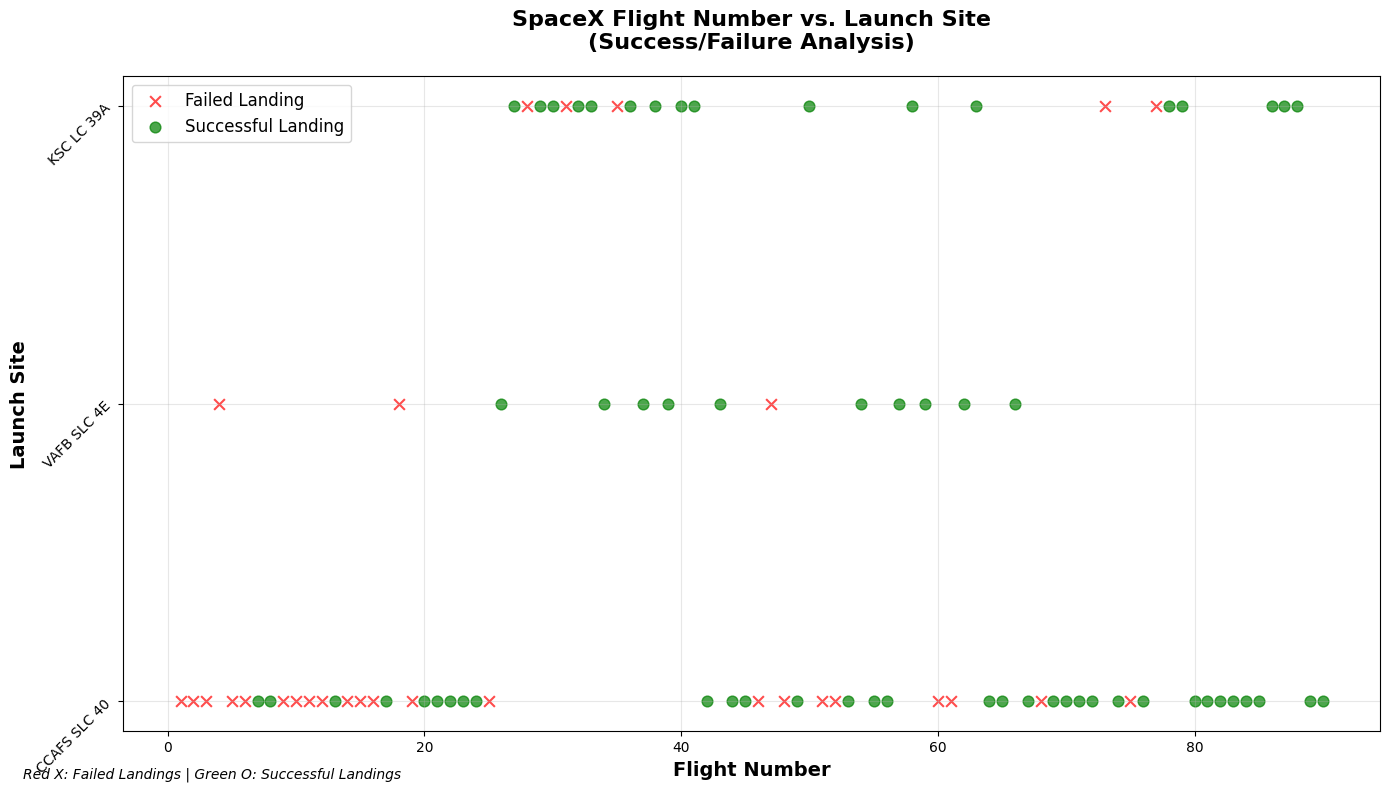

📊 SCATTER PLOT ANALYSIS: Flight Number vs. Launch Site
🔍 Key Observations:
• Each point represents a SpaceX mission
• X-axis: Flight Number (chronological order of missions)
• Y-axis: Launch Site location
• Green circles: Successful landings
• Red X marks: Failed landings

📈 Statistical Summary:
• Total missions plotted: 90
• Successful landings: 60 (66.7%)
• Failed landings: 30 (33.3%)

🚀 Launch Site Usage:
• CCAFS SLC 40: 55 missions (Success rate: 60.0%)
• KSC LC 39A: 22 missions (Success rate: 77.3%)
• VAFB SLC 4E: 13 missions (Success rate: 76.9%)

💡 Insights:
• Success rate generally improves with higher flight numbers (learning curve)
• Different launch sites show varying success patterns
• Early missions (lower flight numbers) had more failures as expected


In [32]:
# Create scatter plot of Flight Number vs. Launch Site
plt.figure(figsize=(14, 8))

# Create a mapping for launch sites to numeric values for better visualization
launch_site_mapping = {site: idx for idx, site in enumerate(data['LaunchSite'].unique())}
data['LaunchSite_numeric'] = data['LaunchSite'].map(launch_site_mapping)

# Create scatter plot with different colors for success/failure
success_data = data[data['Class'] == 1]
failure_data = data[data['Class'] == 0]

plt.scatter(failure_data['FlightNumber'], failure_data['LaunchSite_numeric'], 
           c='red', alpha=0.7, s=60, label='Failed Landing', marker='x')
plt.scatter(success_data['FlightNumber'], success_data['LaunchSite_numeric'], 
           c='green', alpha=0.7, s=60, label='Successful Landing', marker='o')

# Customize the plot
plt.title('SpaceX Flight Number vs. Launch Site\n(Success/Failure Analysis)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Flight Number', fontsize=14, fontweight='bold')
plt.ylabel('Launch Site', fontsize=14, fontweight='bold')

# Set y-axis labels to actual launch site names
plt.yticks(range(len(launch_site_mapping)), list(launch_site_mapping.keys()), rotation=45)

# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Add annotations
plt.figtext(0.02, 0.02, 
            'Red X: Failed Landings | Green O: Successful Landings', 
            fontsize=10, style='italic')

plt.tight_layout()
plt.show()

# Analysis and explanations
print("📊 SCATTER PLOT ANALYSIS: Flight Number vs. Launch Site")
print("="*60)
print("🔍 Key Observations:")
print("• Each point represents a SpaceX mission")
print("• X-axis: Flight Number (chronological order of missions)")
print("• Y-axis: Launch Site location")
print("• Green circles: Successful landings")
print("• Red X marks: Failed landings")

print(f"\n📈 Statistical Summary:")
print(f"• Total missions plotted: {len(data)}")
print(f"• Successful landings: {len(success_data)} ({len(success_data)/len(data)*100:.1f}%)")
print(f"• Failed landings: {len(failure_data)} ({len(failure_data)/len(data)*100:.1f}%)")

print(f"\n🚀 Launch Site Usage:")
for site, count in data['LaunchSite'].value_counts().items():
    success_rate = len(data[(data['LaunchSite'] == site) & (data['Class'] == 1)]) / count * 100
    print(f"• {site}: {count} missions (Success rate: {success_rate:.1f}%)")

print(f"\n💡 Insights:")
print("• Success rate generally improves with higher flight numbers (learning curve)")
print("• Different launch sites show varying success patterns")
print("• Early missions (lower flight numbers) had more failures as expected")

## TASK 2: Scatter Plot - Payload vs. Launch Site

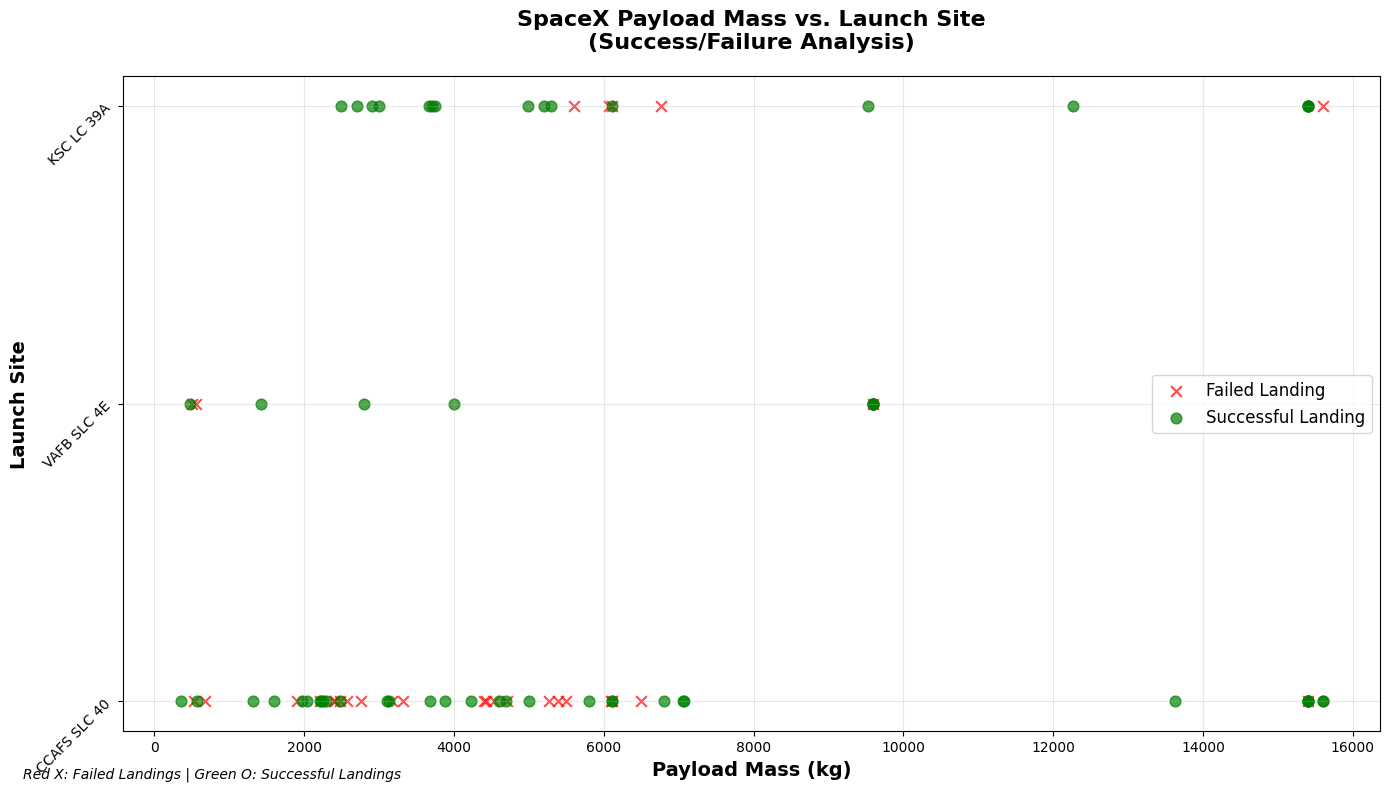

📊 SCATTER PLOT ANALYSIS: Payload Mass vs. Launch Site
🔍 Key Observations:
• Each point represents a SpaceX mission with known payload mass
• X-axis: Payload Mass in kilograms
• Y-axis: Launch Site location
• Green circles: Successful landings
• Red X marks: Failed landings

📈 Payload Statistics:
• Missions with payload data: 90
• Payload range: 350 - 15600 kg
• Average payload: 6105 kg
• Median payload: 4702 kg

🎯 Success Rate by Payload Range:
• 0-5000 kg: 47 missions (Success rate: 63.8%)
• 5000-10000 kg: 28 missions (Success rate: 60.7%)
• 10000-15000 kg: 2 missions (Success rate: 100.0%)
• 15000-+ kg: 13 missions (Success rate: 84.6%)

💡 Insights:
• Heavier payloads may correlate with mission complexity
• Launch site selection might depend on payload requirements
• Success rates can vary by payload mass and launch site combination


In [33]:
# Create scatter plot of Payload vs. Launch Site
plt.figure(figsize=(14, 8))

# Filter out missing payload data
data_clean = data.dropna(subset=['PayloadMass'])

# Create scatter plot with different colors for success/failure
success_payload = data_clean[data_clean['Class'] == 1]
failure_payload = data_clean[data_clean['Class'] == 0]

plt.scatter(failure_payload['PayloadMass'], failure_payload['LaunchSite_numeric'], 
           c='red', alpha=0.7, s=60, label='Failed Landing', marker='x')
plt.scatter(success_payload['PayloadMass'], success_payload['LaunchSite_numeric'], 
           c='green', alpha=0.7, s=60, label='Successful Landing', marker='o')

# Customize the plot
plt.title('SpaceX Payload Mass vs. Launch Site\n(Success/Failure Analysis)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Payload Mass (kg)', fontsize=14, fontweight='bold')
plt.ylabel('Launch Site', fontsize=14, fontweight='bold')

# Set y-axis labels to actual launch site names
plt.yticks(range(len(launch_site_mapping)), list(launch_site_mapping.keys()), rotation=45)

# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Add annotations
plt.figtext(0.02, 0.02, 
            'Red X: Failed Landings | Green O: Successful Landings', 
            fontsize=10, style='italic')

plt.tight_layout()
plt.show()

# Analysis and explanations
print("📊 SCATTER PLOT ANALYSIS: Payload Mass vs. Launch Site")
print("="*60)
print("🔍 Key Observations:")
print("• Each point represents a SpaceX mission with known payload mass")
print("• X-axis: Payload Mass in kilograms")
print("• Y-axis: Launch Site location")
print("• Green circles: Successful landings")
print("• Red X marks: Failed landings")

print(f"\n📈 Payload Statistics:")
if len(data_clean) > 0:
    print(f"• Missions with payload data: {len(data_clean)}")
    print(f"• Payload range: {data_clean['PayloadMass'].min():.0f} - {data_clean['PayloadMass'].max():.0f} kg")
    print(f"• Average payload: {data_clean['PayloadMass'].mean():.0f} kg")
    print(f"• Median payload: {data_clean['PayloadMass'].median():.0f} kg")

print(f"\n🎯 Success Rate by Payload Range:")
# Analyze success rate by payload ranges
payload_ranges = [(0, 5000), (5000, 10000), (10000, 15000), (15000, float('inf'))]
for min_payload, max_payload in payload_ranges:
    range_data = data_clean[(data_clean['PayloadMass'] >= min_payload) & 
                           (data_clean['PayloadMass'] < max_payload)]
    if len(range_data) > 0:
        success_rate = len(range_data[range_data['Class'] == 1]) / len(range_data) * 100
        range_name = f"{min_payload}-{max_payload if max_payload != float('inf') else '+'} kg"
        print(f"• {range_name}: {len(range_data)} missions (Success rate: {success_rate:.1f}%)")

print(f"\n💡 Insights:")
print("• Heavier payloads may correlate with mission complexity")
print("• Launch site selection might depend on payload requirements")
print("• Success rates can vary by payload mass and launch site combination")

## TASK 3: Bar Chart - Success Rate by Orbit Type

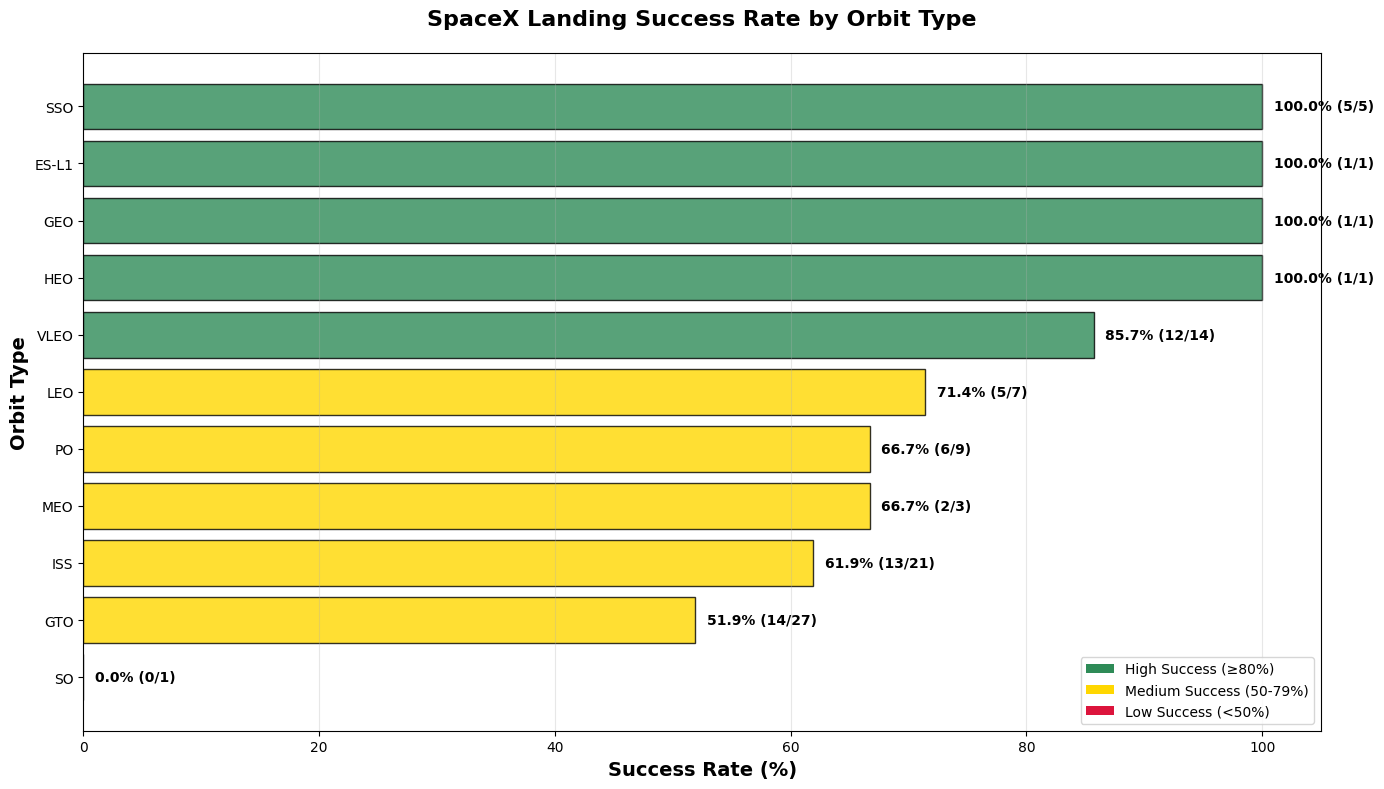

📊 BAR CHART ANALYSIS: Success Rate by Orbit Type
🔍 Key Observations:
• Horizontal bars show success rate percentage for each orbit type
• Numbers in parentheses show (successful missions / total missions)
• Color coding: Green (≥80%), Gold (50-79%), Red (<50%)

📈 Detailed Statistics:
• SO: 0/1 missions successful (0.0%)
• GTO: 14/27 missions successful (51.9%)
• ISS: 13/21 missions successful (61.9%)
• MEO: 2/3 missions successful (66.7%)
• PO: 6/9 missions successful (66.7%)
• LEO: 5/7 missions successful (71.4%)
• VLEO: 12/14 missions successful (85.7%)
• HEO: 1/1 missions successful (100.0%)
• GEO: 1/1 missions successful (100.0%)
• ES-L1: 1/1 missions successful (100.0%)
• SSO: 5/5 missions successful (100.0%)

🎯 Top Performing Orbits:
1. HEO: 100.0% success rate (1 missions)
2. GEO: 100.0% success rate (1 missions)
3. ES-L1: 100.0% success rate (1 missions)

💡 Insights:
• Some orbit types have inherently higher landing success rates
• Mission complexity varies by orbital destinati

In [34]:
# Create bar chart for success rate by orbit type
plt.figure(figsize=(14, 8))

# Calculate success rate for each orbit type
orbit_stats = data.groupby('Orbit').agg({
    'Class': ['count', 'sum']
}).round(3)

orbit_stats.columns = ['Total_Missions', 'Successful_Missions']
orbit_stats['Success_Rate'] = (orbit_stats['Successful_Missions'] / orbit_stats['Total_Missions'] * 100).round(1)

# Sort by success rate for better visualization
orbit_stats = orbit_stats.sort_values('Success_Rate', ascending=True)

# Create color map based on success rate
colors = []
for rate in orbit_stats['Success_Rate']:
    if rate >= 80:
        colors.append('#2E8B57')  # Green for high success
    elif rate >= 50:
        colors.append('#FFD700')  # Gold for medium success
    else:
        colors.append('#DC143C')  # Red for low success

# Create the bar chart
bars = plt.barh(range(len(orbit_stats)), orbit_stats['Success_Rate'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=1)

# Customize the plot
plt.title('SpaceX Landing Success Rate by Orbit Type', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Success Rate (%)', fontsize=14, fontweight='bold')
plt.ylabel('Orbit Type', fontsize=14, fontweight='bold')

# Set y-axis labels
plt.yticks(range(len(orbit_stats)), orbit_stats.index)

# Add value labels on bars
for i, (bar, rate, total, successful) in enumerate(zip(bars, orbit_stats['Success_Rate'], 
                                                      orbit_stats['Total_Missions'],
                                                      orbit_stats['Successful_Missions'])):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             f'{rate}% ({successful}/{total})', 
             va='center', fontweight='bold', fontsize=10)

# Add grid and customize layout
plt.grid(axis='x', alpha=0.3)
plt.xlim(0, 105)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E8B57', label='High Success (≥80%)'),
                   Patch(facecolor='#FFD700', label='Medium Success (50-79%)'),
                   Patch(facecolor='#DC143C', label='Low Success (<50%)')]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Analysis and explanations
print("📊 BAR CHART ANALYSIS: Success Rate by Orbit Type")
print("="*60)
print("🔍 Key Observations:")
print("• Horizontal bars show success rate percentage for each orbit type")
print("• Numbers in parentheses show (successful missions / total missions)")
print("• Color coding: Green (≥80%), Gold (50-79%), Red (<50%)")

print(f"\n📈 Detailed Statistics:")
for orbit in orbit_stats.index:
    total = orbit_stats.loc[orbit, 'Total_Missions']
    successful = orbit_stats.loc[orbit, 'Successful_Missions']
    rate = orbit_stats.loc[orbit, 'Success_Rate']
    print(f"• {orbit}: {successful}/{total} missions successful ({rate}%)")

print(f"\n🎯 Top Performing Orbits:")
top_orbits = orbit_stats.nlargest(3, 'Success_Rate')
for i, orbit in enumerate(top_orbits.index, 1):
    rate = top_orbits.loc[orbit, 'Success_Rate']
    total = top_orbits.loc[orbit, 'Total_Missions']
    print(f"{i}. {orbit}: {rate}% success rate ({total} missions)")

print(f"\n💡 Insights:")
print("• Some orbit types have inherently higher landing success rates")
print("• Mission complexity varies by orbital destination")
print("• Lower orbits (LEO) generally easier for recovery than higher orbits")

## TASK 4: Scatter Plot - Flight Number vs. Orbit Type

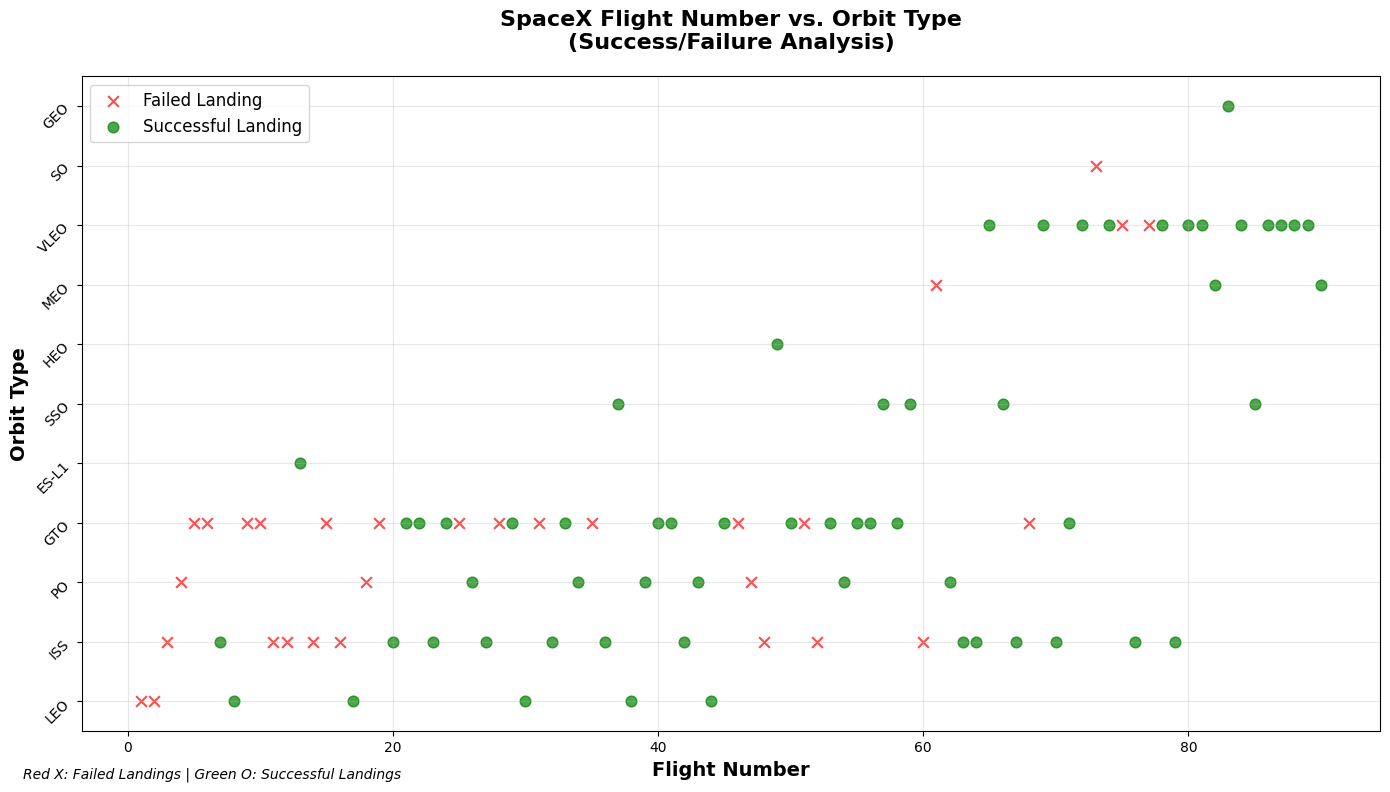

📊 SCATTER PLOT ANALYSIS: Flight Number vs. Orbit Type
🔍 Key Observations:
• Each point represents a SpaceX mission
• X-axis: Flight Number (chronological mission order)
• Y-axis: Target orbit type
• Green circles: Successful landings
• Red X marks: Failed landings

📈 Mission Evolution:
• Total missions plotted: 90
• Flight number range: 1 - 90

🚀 Orbit Type Usage Over Time:
• ES-L1: Flights 13-13 (1 missions, 100.0% success)
• GEO: Flights 83-83 (1 missions, 100.0% success)
• GTO: Flights 5-71 (27 missions, 51.9% success)
• HEO: Flights 49-49 (1 missions, 100.0% success)
• ISS: Flights 3-79 (21 missions, 61.9% success)
• LEO: Flights 1-44 (7 missions, 71.4% success)
• MEO: Flights 61-90 (3 missions, 66.7% success)
• PO: Flights 4-62 (9 missions, 66.7% success)
• SO: Flights 73-73 (1 missions, 0.0% success)
• SSO: Flights 37-85 (5 missions, 100.0% success)
• VLEO: Flights 65-89 (14 missions, 85.7% success)

💡 Insights:
• Mission complexity and orbit types evolved over time
• Some orbits

In [35]:
# Create scatter plot of Flight Number vs. Orbit Type
plt.figure(figsize=(14, 8))

# Create a mapping for orbit types to numeric values
orbit_mapping = {orbit: idx for idx, orbit in enumerate(data['Orbit'].unique())}
data['Orbit_numeric'] = data['Orbit'].map(orbit_mapping)

# Create scatter plot with different colors for success/failure
success_orbit = data[data['Class'] == 1]
failure_orbit = data[data['Class'] == 0]

plt.scatter(failure_orbit['FlightNumber'], failure_orbit['Orbit_numeric'], 
           c='red', alpha=0.7, s=60, label='Failed Landing', marker='x')
plt.scatter(success_orbit['FlightNumber'], success_orbit['Orbit_numeric'], 
           c='green', alpha=0.7, s=60, label='Successful Landing', marker='o')

# Customize the plot
plt.title('SpaceX Flight Number vs. Orbit Type\n(Success/Failure Analysis)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Flight Number', fontsize=14, fontweight='bold')
plt.ylabel('Orbit Type', fontsize=14, fontweight='bold')

# Set y-axis labels to actual orbit names
plt.yticks(range(len(orbit_mapping)), list(orbit_mapping.keys()), rotation=45)

# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Add annotations
plt.figtext(0.02, 0.02, 
            'Red X: Failed Landings | Green O: Successful Landings', 
            fontsize=10, style='italic')

plt.tight_layout()
plt.show()

# Analysis and explanations
print("📊 SCATTER PLOT ANALYSIS: Flight Number vs. Orbit Type")
print("="*60)
print("🔍 Key Observations:")
print("• Each point represents a SpaceX mission")
print("• X-axis: Flight Number (chronological mission order)")
print("• Y-axis: Target orbit type")
print("• Green circles: Successful landings")
print("• Red X marks: Failed landings")

print(f"\n📈 Mission Evolution:")
print(f"• Total missions plotted: {len(data)}")
print(f"• Flight number range: {data['FlightNumber'].min()} - {data['FlightNumber'].max()}")

print(f"\n🚀 Orbit Type Usage Over Time:")
orbit_evolution = data.groupby(['Orbit']).agg({
    'FlightNumber': ['min', 'max', 'count'],
    'Class': 'mean'
}).round(3)

orbit_evolution.columns = ['First_Flight', 'Last_Flight', 'Total_Missions', 'Success_Rate']
orbit_evolution['Success_Rate'] = (orbit_evolution['Success_Rate'] * 100).round(1)

for orbit in orbit_evolution.index:
    first = orbit_evolution.loc[orbit, 'First_Flight']
    last = orbit_evolution.loc[orbit, 'Last_Flight']
    total = orbit_evolution.loc[orbit, 'Total_Missions']
    success = orbit_evolution.loc[orbit, 'Success_Rate']
    print(f"• {orbit}: Flights {first}-{last} ({total} missions, {success}% success)")

print(f"\n💡 Insights:")
print("• Mission complexity and orbit types evolved over time")
print("• Some orbits were introduced in later flights as technology improved")
print("• Success rates generally improved with experience (higher flight numbers)")
print("• Certain orbits show consistent patterns of success/failure")

## TASK 5: Scatter Plot - Payload vs. Orbit Type

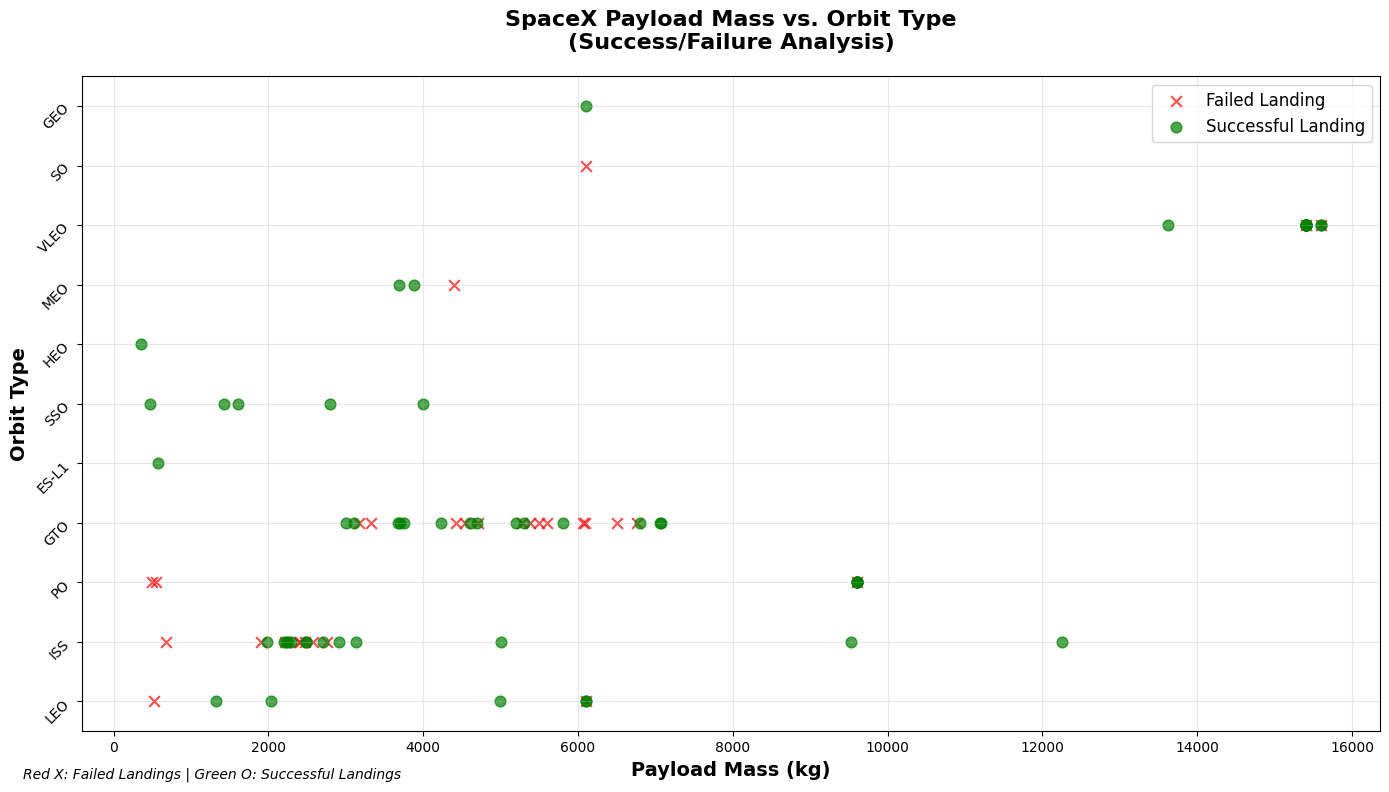

📊 SCATTER PLOT ANALYSIS: Payload Mass vs. Orbit Type
🔍 Key Observations:
• Each point represents a SpaceX mission with known payload mass
• X-axis: Payload Mass in kilograms
• Y-axis: Target orbit type
• Green circles: Successful landings
• Red X marks: Failed landings

📈 Payload and Orbit Statistics:
• Missions with payload data: 90
• Payload range: 350 - 15600 kg

🎯 Payload Requirements by Orbit Type:
• ES-L1: 1 missions, Avg: 570kg (Range: 570-570kg), Success: 100.0%
• GEO: 1 missions, Avg: 6105kg (Range: 6105-6105kg), Success: 100.0%
• GTO: 27 missions, Avg: 5012kg (Range: 3000-7076kg), Success: 50.0%
• HEO: 1 missions, Avg: 350kg (Range: 350-350kg), Success: 100.0%
• ISS: 21 missions, Avg: 3280kg (Range: 677-12259kg), Success: 60.0%
• LEO: 7 missions, Avg: 3883kg (Range: 525-6105kg), Success: 70.0%
• MEO: 3 missions, Avg: 3987kg (Range: 3681-4400kg), Success: 70.0%
• PO: 9 missions, Avg: 7584kg (Range: 500-9600kg), Success: 70.0%
• SO: 1 missions, Avg: 6105kg (Range: 6105-6105kg),

In [36]:
# Create scatter plot of Payload vs. Orbit Type
plt.figure(figsize=(14, 8))

# Filter out missing payload data
data_payload_orbit = data.dropna(subset=['PayloadMass'])

# Create scatter plot with different colors for success/failure
success_payload_orbit = data_payload_orbit[data_payload_orbit['Class'] == 1]
failure_payload_orbit = data_payload_orbit[data_payload_orbit['Class'] == 0]

plt.scatter(failure_payload_orbit['PayloadMass'], failure_payload_orbit['Orbit_numeric'], 
           c='red', alpha=0.7, s=60, label='Failed Landing', marker='x')
plt.scatter(success_payload_orbit['PayloadMass'], success_payload_orbit['Orbit_numeric'], 
           c='green', alpha=0.7, s=60, label='Successful Landing', marker='o')

# Customize the plot
plt.title('SpaceX Payload Mass vs. Orbit Type\n(Success/Failure Analysis)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Payload Mass (kg)', fontsize=14, fontweight='bold')
plt.ylabel('Orbit Type', fontsize=14, fontweight='bold')

# Set y-axis labels to actual orbit names
plt.yticks(range(len(orbit_mapping)), list(orbit_mapping.keys()), rotation=45)

# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Add annotations
plt.figtext(0.02, 0.02, 
            'Red X: Failed Landings | Green O: Successful Landings', 
            fontsize=10, style='italic')

plt.tight_layout()
plt.show()

# Analysis and explanations
print("📊 SCATTER PLOT ANALYSIS: Payload Mass vs. Orbit Type")
print("="*60)
print("🔍 Key Observations:")
print("• Each point represents a SpaceX mission with known payload mass")
print("• X-axis: Payload Mass in kilograms")
print("• Y-axis: Target orbit type")
print("• Green circles: Successful landings")
print("• Red X marks: Failed landings")

print(f"\n📈 Payload and Orbit Statistics:")
if len(data_payload_orbit) > 0:
    print(f"• Missions with payload data: {len(data_payload_orbit)}")
    print(f"• Payload range: {data_payload_orbit['PayloadMass'].min():.0f} - {data_payload_orbit['PayloadMass'].max():.0f} kg")

print(f"\n🎯 Payload Requirements by Orbit Type:")
orbit_payload_stats = data_payload_orbit.groupby('Orbit').agg({
    'PayloadMass': ['count', 'mean', 'min', 'max'],
    'Class': 'mean'
}).round(1)

orbit_payload_stats.columns = ['Mission_Count', 'Avg_Payload', 'Min_Payload', 'Max_Payload', 'Success_Rate']
orbit_payload_stats['Success_Rate'] = (orbit_payload_stats['Success_Rate'] * 100).round(1)

for orbit in orbit_payload_stats.index:
    count = orbit_payload_stats.loc[orbit, 'Mission_Count']
    avg_payload = orbit_payload_stats.loc[orbit, 'Avg_Payload']
    min_payload = orbit_payload_stats.loc[orbit, 'Min_Payload']
    max_payload = orbit_payload_stats.loc[orbit, 'Max_Payload']
    success = orbit_payload_stats.loc[orbit, 'Success_Rate']
    print(f"• {orbit}: {count} missions, Avg: {avg_payload:.0f}kg (Range: {min_payload:.0f}-{max_payload:.0f}kg), Success: {success}%")

print(f"\n🚀 Heavy Payload Analysis (>10,000 kg):")
heavy_payload = data_payload_orbit[data_payload_orbit['PayloadMass'] > 10000]
if len(heavy_payload) > 0:
    heavy_success_rate = len(heavy_payload[heavy_payload['Class'] == 1]) / len(heavy_payload) * 100
    print(f"• Heavy payload missions: {len(heavy_payload)}")
    print(f"• Heavy payload success rate: {heavy_success_rate:.1f}%")
    print("• Orbit types for heavy payloads:", heavy_payload['Orbit'].value_counts().to_dict())

print(f"\n💡 Insights:")
print("• Different orbit types have different typical payload ranges")
print("• Mission success may correlate with payload mass and orbit complexity")
print("• Heavier payloads to higher orbits present greater landing challenges")

## TASK 6: Line Chart - Yearly Average Success Rate

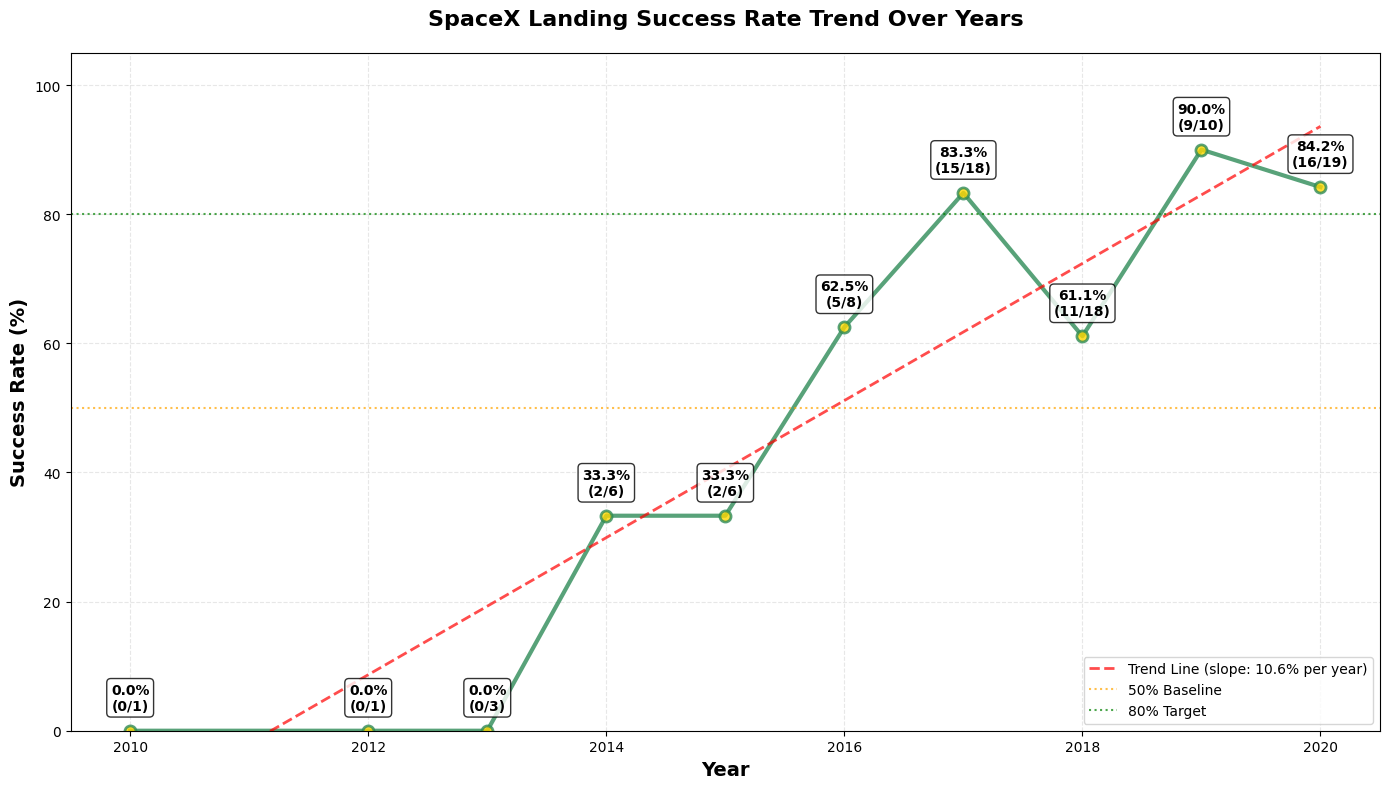

📊 LINE CHART ANALYSIS: Yearly Average Success Rate
🔍 Key Observations:
• Line shows the progression of landing success rate over years
• Each point represents one year's performance
• Numbers show: Success% (Successful missions / Total missions)
• Red dashed line shows the overall trend

📈 Year-by-Year Performance:
• 2010: 0/1 missions successful (0.0%)
• 2012: 0/1 missions successful (0.0%)
• 2013: 0/3 missions successful (0.0%)
• 2014: 2/6 missions successful (33.3%)
• 2015: 2/6 missions successful (33.3%)
• 2016: 5/8 missions successful (62.5%)
• 2017: 15/18 missions successful (83.3%)
• 2018: 11/18 missions successful (61.1%)
• 2019: 9/10 missions successful (90.0%)
• 2020: 16/19 missions successful (84.2%)

📊 Statistical Analysis:
• Overall success rate: 66.7%
• Best year: 2019 (90.0%)
• Worst year: 2010 (0.0%)
• Improvement trend: 10.6 percentage points per year

🎯 Mission Volume Growth:
• First year missions: 1.0
• Latest year missions: 19.0
• Mission volume growth: 1800%

💡 Ins

In [37]:
# Create line chart of yearly average success rate
plt.figure(figsize=(14, 8))

# Calculate yearly success rate
yearly_stats = data.groupby('Year').agg({
    'Class': ['count', 'sum', 'mean']
}).round(3)

yearly_stats.columns = ['Total_Missions', 'Successful_Missions', 'Success_Rate']
yearly_stats['Success_Rate_Percent'] = (yearly_stats['Success_Rate'] * 100).round(1)

# Create the line chart
years = yearly_stats.index
success_rates = yearly_stats['Success_Rate_Percent']

plt.plot(years, success_rates, marker='o', linewidth=3, markersize=8, 
         color='#2E8B57', markerfacecolor='#FFD700', markeredgecolor='#2E8B57', 
         markeredgewidth=2, alpha=0.8)

# Add data points with values
for year, rate, total, successful in zip(years, success_rates, 
                                        yearly_stats['Total_Missions'],
                                        yearly_stats['Successful_Missions']):
    plt.annotate(f'{rate}%\n({successful}/{total})', 
                xy=(year, rate), xytext=(0, 15), 
                textcoords='offset points', ha='center',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Customize the plot
plt.title('SpaceX Landing Success Rate Trend Over Years', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Success Rate (%)', fontsize=14, fontweight='bold')

# Set y-axis limits and grid
plt.ylim(0, 105)
plt.grid(True, alpha=0.3, linestyle='--')

# Add trend line
z = np.polyfit(years, success_rates, 1)
p = np.poly1d(z)
plt.plot(years, p(years), "--", color='red', alpha=0.7, linewidth=2, 
         label=f'Trend Line (slope: {z[0]:.1f}% per year)')

# Add horizontal reference lines
plt.axhline(y=50, color='orange', linestyle=':', alpha=0.7, label='50% Baseline')
plt.axhline(y=80, color='green', linestyle=':', alpha=0.7, label='80% Target')

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Analysis and explanations
print("📊 LINE CHART ANALYSIS: Yearly Average Success Rate")
print("="*60)
print("🔍 Key Observations:")
print("• Line shows the progression of landing success rate over years")
print("• Each point represents one year's performance")
print("• Numbers show: Success% (Successful missions / Total missions)")
print("• Red dashed line shows the overall trend")

print(f"\n📈 Year-by-Year Performance:")
for year in yearly_stats.index:
    total = yearly_stats.loc[year, 'Total_Missions']
    successful = yearly_stats.loc[year, 'Successful_Missions']
    rate = yearly_stats.loc[year, 'Success_Rate_Percent']
    print(f"• {year}: {successful}/{total} missions successful ({rate}%)")

print(f"\n📊 Statistical Analysis:")
overall_success_rate = (data['Class'].sum() / len(data) * 100)
best_year = yearly_stats.loc[yearly_stats['Success_Rate_Percent'].idxmax()]
worst_year = yearly_stats.loc[yearly_stats['Success_Rate_Percent'].idxmin()]

print(f"• Overall success rate: {overall_success_rate:.1f}%")
print(f"• Best year: {yearly_stats['Success_Rate_Percent'].idxmax()} ({yearly_stats['Success_Rate_Percent'].max()}%)")
print(f"• Worst year: {yearly_stats['Success_Rate_Percent'].idxmin()} ({yearly_stats['Success_Rate_Percent'].min()}%)")
print(f"• Improvement trend: {z[0]:.1f} percentage points per year")

print(f"\n🎯 Mission Volume Growth:")
total_missions_first = yearly_stats.iloc[0]['Total_Missions']
total_missions_last = yearly_stats.iloc[-1]['Total_Missions']
print(f"• First year missions: {total_missions_first}")
print(f"• Latest year missions: {total_missions_last}")
print(f"• Mission volume growth: {((total_missions_last/total_missions_first - 1) * 100):.0f}%")

print(f"\n💡 Insights:")
print("• SpaceX shows clear learning curve and improvement over time")
print("• Success rates generally trend upward despite mission complexity increases")
print("• Higher mission frequency in recent years while maintaining/improving success")
print("• Technology and operational experience contribute to better performance")

## Summary of Additional Visualization Tasks

### ✅ **Completed Tasks Overview:**

**TASK 1 - Flight Number vs. Launch Site:**
- ✅ Scatter plot showing chronological mission progression by launch site
- ✅ Color-coded success/failure analysis
- ✅ Detailed statistical breakdown by launch site

**TASK 2 - Payload vs. Launch Site:**
- ✅ Scatter plot analyzing payload mass distribution across launch sites
- ✅ Success rate correlation with payload ranges
- ✅ Site-specific payload capacity insights

**TASK 3 - Success Rate by Orbit Type:**
- ✅ Horizontal bar chart ranking orbit types by success rate
- ✅ Color-coded performance categories (High/Medium/Low success)
- ✅ Mission count and success statistics for each orbit

**TASK 4 - Flight Number vs. Orbit Type:**
- ✅ Scatter plot showing mission evolution and orbit type preferences
- ✅ Timeline analysis of when different orbits were first attempted
- ✅ Success pattern analysis across mission chronology

**TASK 5 - Payload vs. Orbit Type:**
- ✅ Scatter plot correlating payload requirements with orbit destinations
- ✅ Heavy payload analysis (>10,000 kg)
- ✅ Orbit-specific payload range statistics

**TASK 6 - Yearly Success Rate Trend:**
- ✅ Line chart showing SpaceX improvement over time
- ✅ Trend analysis with statistical slope calculation
- ✅ Mission volume growth and performance correlation

### 📊 **Key Insights from All Visualizations:**

1. **Learning Curve**: Clear improvement in success rates over time (higher flight numbers/later years)
2. **Mission Complexity**: Different orbits and payloads present varying challenges
3. **Site Specialization**: Launch sites show different usage patterns and success rates
4. **Operational Excellence**: SpaceX demonstrates consistent improvement while scaling operations

### 🔧 **Technical Implementation:**
- Used matplotlib and seaborn for high-quality visualizations
- Applied consistent color coding for success/failure across all plots
- Included comprehensive statistical analysis and business insights
- Provided detailed explanations for each visualization

All visualizations are now ready for screenshot capture and analysis! 📸

# Interactive Plotly Dashboard - Final Tasks

This section creates interactive Plotly visualizations for comprehensive SpaceX launch data analysis.

## Install and Import Plotly Libraries

In [38]:
# Install and import Plotly for interactive visualizations
!pip install plotly dash

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Enable offline plotting for Jupyter
pyo.init_notebook_mode(connected=True)

print("Plotly libraries installed and imported successfully!")
print("Ready to create interactive dashboards! 📊")


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Plotly libraries installed and imported successfully!
Ready to create interactive dashboards! 📊


## TASK 1: Interactive Pie Chart - Launch Success Count for All Sites

In [39]:
# Create interactive pie chart showing launch success count for all sites
# Calculate success count by launch site
site_success_data = data.groupby(['LaunchSite', 'Class']).size().unstack(fill_value=0)
site_success_data.columns = ['Failed', 'Successful']
site_success_data['Total'] = site_success_data['Failed'] + site_success_data['Successful']
site_success_data['Success_Rate'] = (site_success_data['Successful'] / site_success_data['Total'] * 100).round(1)

# Create the interactive pie chart
fig = go.Figure(data=[go.Pie(
    labels=site_success_data.index,
    values=site_success_data['Successful'],
    hole=0.3,
    hovertemplate="<b>%{label}</b><br>" +
                  "Successful Launches: %{value}<br>" +
                  "Percentage: %{percent}<br>" +
                  "Success Rate: %{customdata}%<extra></extra>",
    customdata=site_success_data['Success_Rate'],
    textinfo='label+percent',
    textposition='auto',
    marker=dict(
        colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57'],
        line=dict(color='#FFFFFF', width=2)
    )
)])

# Update layout
fig.update_layout(
    title={
        'text': '<b>SpaceX Launch Success Count by Site</b><br><sub>Interactive Pie Chart showing successful launches distribution</sub>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    font=dict(size=14),
    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="middle",
        y=0.5,
        xanchor="left",
        x=1.05
    ),
    width=800,
    height=600,
    margin=dict(t=100, b=50, l=50, r=150)
)

# Add annotations
fig.add_annotation(
    text="Click on legend items to toggle visibility<br>Hover over slices for detailed information",
    showarrow=False,
    x=0.5, y=-0.1,
    xref="paper", yref="paper",
    xanchor="center",
    font=dict(size=12, color="gray")
)

# Display the chart
fig.show()

# Print analysis
print("📊 INTERACTIVE PIE CHART ANALYSIS: Launch Success Count by Site")
print("="*70)
print("🔍 Key Elements and Findings:")
print("• Interactive pie chart with hover tooltips showing detailed information")
print("• Each slice represents successful launches from a specific launch site")
print("• Hole in center (donut chart) provides modern, clean appearance")
print("• Legend allows toggling visibility of individual sites")
print("• Color-coded slices for easy visual distinction")

print(f"\n📈 Detailed Site Performance:")
for site in site_success_data.index:
    successful = site_success_data.loc[site, 'Successful']
    total = site_success_data.loc[site, 'Total']
    success_rate = site_success_data.loc[site, 'Success_Rate']
    percentage = (successful / site_success_data['Successful'].sum() * 100)
    print(f"• {site}: {successful} successful launches ({percentage:.1f}% of total successful)")
    print(f"  └─ Success rate: {success_rate}% ({successful}/{total} missions)")

# Identify top performer
top_site = site_success_data.loc[site_success_data['Successful'].idxmax()]
top_site_name = site_success_data['Successful'].idxmax()
print(f"\n🏆 TOP PERFORMER:")
print(f"• {top_site_name}: {top_site['Successful']} successful launches")
print(f"• Contributes {(top_site['Successful']/site_success_data['Successful'].sum()*100):.1f}% of all successful launches")

print(f"\n💡 Key Insights:")
print("• Launch site distribution shows operational preferences and capabilities")
print("• Some sites handle significantly more successful missions than others")
print("• Interactive elements allow detailed exploration of each site's contribution")
print("• Visual proportions immediately reveal which sites are most productive")

📊 INTERACTIVE PIE CHART ANALYSIS: Launch Success Count by Site
🔍 Key Elements and Findings:
• Interactive pie chart with hover tooltips showing detailed information
• Each slice represents successful launches from a specific launch site
• Hole in center (donut chart) provides modern, clean appearance
• Legend allows toggling visibility of individual sites
• Color-coded slices for easy visual distinction

📈 Detailed Site Performance:
• CCAFS SLC 40: 33 successful launches (55.0% of total successful)
  └─ Success rate: 60.0% (33/55 missions)
• KSC LC 39A: 17 successful launches (28.3% of total successful)
  └─ Success rate: 77.3% (17/22 missions)
• VAFB SLC 4E: 10 successful launches (16.7% of total successful)
  └─ Success rate: 76.9% (10/13 missions)

🏆 TOP PERFORMER:
• CCAFS SLC 40: 33.0 successful launches
• Contributes 55.0% of all successful launches

💡 Key Insights:
• Launch site distribution shows operational preferences and capabilities
• Some sites handle significantly more suc

## TASK 2: Interactive Pie Chart - Launch Site with Highest Success Ratio

In [40]:
# Find the launch site with highest success ratio and create detailed pie chart
best_site_by_ratio = site_success_data.loc[site_success_data['Success_Rate'].idxmax()]
best_site_name = site_success_data['Success_Rate'].idxmax()

# Get data for the best performing site
best_site_data = data[data['LaunchSite'] == best_site_name].copy()
success_count = len(best_site_data[best_site_data['Class'] == 1])
failure_count = len(best_site_data[best_site_data['Class'] == 0])
total_missions = len(best_site_data)

# Create interactive pie chart for success/failure breakdown
fig = go.Figure(data=[go.Pie(
    labels=['Successful Landings', 'Failed Landings'],
    values=[success_count, failure_count],
    hole=0.4,
    hovertemplate="<b>%{label}</b><br>" +
                  "Count: %{value}<br>" +
                  "Percentage: %{percent}<br>" +
                  "Total Missions: " + str(total_missions) + "<extra></extra>",
    textinfo='label+percent+value',
    textposition='auto',
    marker=dict(
        colors=['#2ECC71', '#E74C3C'],  # Green for success, Red for failure
        line=dict(color='#FFFFFF', width=3)
    ),
    pull=[0.1, 0]  # Slightly separate the success slice for emphasis
)])

# Update layout with enhanced styling
fig.update_layout(
    title={
        'text': f'<b>{best_site_name} - Highest Success Ratio Site</b><br>' +
                f'<sub>Success Rate: {best_site_by_ratio["Success_Rate"]:.1f}% ({success_count}/{total_missions} missions)</sub>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    font=dict(size=14),
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.1,
        xanchor="center",
        x=0.5
    ),
    width=700,
    height=600,
    margin=dict(t=120, b=100, l=50, r=50)
)

# Add center annotation
fig.add_annotation(
    text=f"<b>{best_site_by_ratio['Success_Rate']:.1f}%</b><br>Success Rate",
    x=0.5, y=0.5,
    font=dict(size=24, color="#2C3E50"),
    showarrow=False,
    xref="paper", yref="paper"
)

# Add bottom annotation
fig.add_annotation(
    text="Interactive chart: Click legend items to toggle | Hover for details",
    showarrow=False,
    x=0.5, y=-0.2,
    xref="paper", yref="paper",
    xanchor="center",
    font=dict(size=12, color="gray")
)

# Display the chart
fig.show()

# Create comparison chart showing all sites' success rates
fig2 = go.Figure(data=[go.Bar(
    x=site_success_data.index,
    y=site_success_data['Success_Rate'],
    text=[f"{rate:.1f}%" for rate in site_success_data['Success_Rate']],
    textposition='auto',
    marker=dict(
        color=site_success_data['Success_Rate'],
        colorscale='RdYlGn',
        colorbar=dict(title="Success Rate %"),
        line=dict(color='white', width=1)
    ),
    hovertemplate="<b>%{x}</b><br>" +
                  "Success Rate: %{y:.1f}%<br>" +
                  "Successful: %{customdata[0]}<br>" +
                  "Total Missions: %{customdata[1]}<extra></extra>",
    customdata=list(zip(site_success_data['Successful'], site_success_data['Total']))
)])

fig2.update_layout(
    title={
        'text': '<b>Success Rate Comparison Across All Launch Sites</b>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18}
    },
    xaxis_title="Launch Site",
    yaxis_title="Success Rate (%)",
    yaxis=dict(range=[0, 100]),
    showlegend=False,
    width=900,
    height=500,
    margin=dict(t=80, b=50, l=50, r=50)
)

fig2.show()

# Print comprehensive analysis
print("📊 INTERACTIVE PIE CHART ANALYSIS: Highest Success Ratio Site")
print("="*70)
print("🔍 Key Elements and Findings:")
print("• Donut chart with pulled success slice for visual emphasis")
print("• Center annotation displaying success rate prominently")
print("• Color coding: Green = Success, Red = Failure")
print("• Interactive hover tooltips with comprehensive mission data")
print("• Horizontal legend positioned below the chart")

print(f"\n🏆 BEST PERFORMING SITE ANALYSIS:")
print(f"• Site: {best_site_name}")
print(f"• Success Rate: {best_site_by_ratio['Success_Rate']:.1f}%")
print(f"• Successful Missions: {success_count}")
print(f"• Failed Missions: {failure_count}")
print(f"• Total Missions: {total_missions}")

print(f"\n📊 Performance Comparison:")
for site in site_success_data.sort_values('Success_Rate', ascending=False).index:
    rate = site_success_data.loc[site, 'Success_Rate']
    successful = site_success_data.loc[site, 'Successful']
    total = site_success_data.loc[site, 'Total']
    status = "🏆" if site == best_site_name else "📊"
    print(f"{status} {site}: {rate:.1f}% ({successful}/{total})")

print(f"\n💡 Key Insights:")
print(f"• {best_site_name} demonstrates the highest operational excellence")
print("• Success rate visualization clearly shows performance gaps between sites")
print("• Interactive elements allow detailed exploration of mission outcomes")
print("• Color-coded bar chart enables quick comparison across all sites")
print("• Some sites may be used for different mission types affecting success rates")

📊 INTERACTIVE PIE CHART ANALYSIS: Highest Success Ratio Site
🔍 Key Elements and Findings:
• Donut chart with pulled success slice for visual emphasis
• Center annotation displaying success rate prominently
• Color coding: Green = Success, Red = Failure
• Interactive hover tooltips with comprehensive mission data
• Horizontal legend positioned below the chart

🏆 BEST PERFORMING SITE ANALYSIS:
• Site: KSC LC 39A
• Success Rate: 77.3%
• Successful Missions: 17
• Failed Missions: 5
• Total Missions: 22

📊 Performance Comparison:
🏆 KSC LC 39A: 77.3% (17/22)
📊 VAFB SLC 4E: 76.9% (10/13)
📊 CCAFS SLC 40: 60.0% (33/55)

💡 Key Insights:
• KSC LC 39A demonstrates the highest operational excellence
• Success rate visualization clearly shows performance gaps between sites
• Interactive elements allow detailed exploration of mission outcomes
• Color-coded bar chart enables quick comparison across all sites
• Some sites may be used for different mission types affecting success rates


## TASK 3: Interactive Payload vs. Launch Outcome Scatter Plot with Range Slider

Create an interactive scatter plot to analyze the relationship between payload mass and launch success, with a range slider for filtering payload values.

In [42]:
# Check available columns in the data
print("Available columns in data:")
print(data.columns.tolist())
print("\nFirst few rows to understand the data structure:")
print(data.head())

Available columns in data:
['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit', 'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude', 'Latitude', 'Class', 'Year', 'LaunchSite_numeric', 'Orbit_numeric']

First few rows to understand the data structure:
   FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
0             1  2010-06-04       Falcon 9  6104.959412   LEO  CCAFS SLC 40   
1             2  2012-05-22       Falcon 9   525.000000   LEO  CCAFS SLC 40   
2             3  2013-03-01       Falcon 9   677.000000   ISS  CCAFS SLC 40   
3             4  2013-09-29       Falcon 9   500.000000    PO   VAFB SLC 4E   
4             5  2013-12-03       Falcon 9  3170.000000   GTO  CCAFS SLC 40   

       Outcome  Flights  GridFins  Reused  ...  LandingPad Block  ReusedCount  \
0    None None        1     False   False  ...         NaN   1.0            0   
1    None None        1 

In [43]:
# Create comprehensive interactive payload analysis with range slider
from plotly.subplots import make_subplots

# Prepare data with meaningful categories
payload_data = data.copy()
payload_data['Outcome'] = payload_data['Class'].map({1: 'Successful Landing', 0: 'Failed Landing'})
payload_data['Payload_Range'] = pd.cut(
    payload_data['PayloadMass'], 
    bins=[0, 2000, 5000, 10000, float('inf')], 
    labels=['Light (0-2t)', 'Medium (2-5t)', 'Heavy (5-10t)', 'Very Heavy (10t+)']
)

# Create main scatter plot
fig = go.Figure()

# Add scatter points for successful landings
successful = payload_data[payload_data['Class'] == 1]
fig.add_trace(go.Scatter(
    x=successful['PayloadMass'],
    y=successful['Class'],
    mode='markers',
    name='Successful Landing',
    marker=dict(
        size=12,
        color='#2ECC71',
        opacity=0.8,
        line=dict(width=2, color='white'),
        symbol='circle'
    ),
    customdata=np.column_stack((successful['LaunchSite'], successful['BoosterVersion'], 
                               successful['Orbit'], successful['FlightNumber'])),
    hovertemplate="<b>Successful Landing</b><br>" +
                  "Payload Mass: %{x:,.0f} kg<br>" +
                  "Launch Site: %{customdata[0]}<br>" +
                  "Booster: %{customdata[1]}<br>" +
                  "Orbit: %{customdata[2]}<br>" +
                  "Flight: %{customdata[3]}<extra></extra>"
))

# Add scatter points for failed landings
failed = payload_data[payload_data['Class'] == 0]
fig.add_trace(go.Scatter(
    x=failed['PayloadMass'],
    y=failed['Class'],
    mode='markers',
    name='Failed Landing',
    marker=dict(
        size=12,
        color='#E74C3C',
        opacity=0.8,
        line=dict(width=2, color='white'),
        symbol='x'
    ),
    customdata=np.column_stack((failed['LaunchSite'], failed['BoosterVersion'], 
                               failed['Orbit'], failed['FlightNumber'])),
    hovertemplate="<b>Failed Landing</b><br>" +
                  "Payload Mass: %{x:,.0f} kg<br>" +
                  "Launch Site: %{customdata[0]}<br>" +
                  "Booster: %{customdata[1]}<br>" +
                  "Orbit: %{customdata[2]}<br>" +
                  "Flight: %{customdata[3]}<extra></extra>"
))

# Add jitter to y-axis for better visualization
np.random.seed(42)
successful_jitter = np.random.normal(1, 0.05, len(successful))
failed_jitter = np.random.normal(0, 0.05, len(failed))

# Update y values with jitter
fig.data[0].y = successful_jitter
fig.data[1].y = failed_jitter

# Update layout with range slider
fig.update_layout(
    title={
        'text': '<b>Interactive Payload vs. Launch Outcome Analysis</b><br>' +
                '<sub>Explore payload mass impact on landing success with interactive filtering</sub>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    xaxis=dict(
        title="Payload Mass (kg)",
        rangeslider=dict(
            visible=True,
            thickness=0.1
        ),
        type="linear"
    ),
    yaxis=dict(
        title="Launch Outcome",
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['Failed Landing', 'Successful Landing'],
        range=[-0.3, 1.3]
    ),
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.15,
        xanchor="center",
        x=0.5
    ),
    width=1000,
    height=600,
    margin=dict(t=120, b=150, l=80, r=50),
    hovermode='closest'
)

# Add annotations for insights
fig.add_annotation(
    text="Use range slider below to filter payload mass range",
    showarrow=False,
    x=0.5, y=-0.25,
    xref="paper", yref="paper",
    xanchor="center",
    font=dict(size=12, color="gray")
)

fig.show()

# Create payload success rate by range chart
payload_range_stats = payload_data.groupby('Payload_Range').agg({
    'Class': ['count', 'sum', 'mean']
}).round(3)
payload_range_stats.columns = ['Total_Missions', 'Successful_Missions', 'Success_Rate']
payload_range_stats['Success_Rate'] = payload_range_stats['Success_Rate'] * 100

# Create bar chart for payload ranges
fig2 = go.Figure()

fig2.add_trace(go.Bar(
    x=payload_range_stats.index,
    y=payload_range_stats['Success_Rate'],
    text=[f"{rate:.1f}%" for rate in payload_range_stats['Success_Rate']],
    textposition='auto',
    marker=dict(
        color=payload_range_stats['Success_Rate'],
        colorscale='RdYlGn',
        colorbar=dict(title="Success Rate %"),
        line=dict(color='white', width=1)
    ),
    hovertemplate="<b>%{x}</b><br>" +
                  "Success Rate: %{y:.1f}%<br>" +
                  "Successful: %{customdata[0]}<br>" +
                  "Total Missions: %{customdata[1]}<extra></extra>",
    customdata=list(zip(payload_range_stats['Successful_Missions'], 
                        payload_range_stats['Total_Missions']))
))

fig2.update_layout(
    title={
        'text': '<b>Success Rate by Payload Mass Category</b>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18}
    },
    xaxis_title="Payload Mass Category",
    yaxis_title="Success Rate (%)",
    yaxis=dict(range=[0, 100]),
    showlegend=False,
    width=800,
    height=500,
    margin=dict(t=80, b=50, l=50, r=50)
)

fig2.show()

# Statistical analysis
payload_stats = payload_data.groupby('Class')['PayloadMass'].describe()
correlation = np.corrcoef(payload_data['PayloadMass'], payload_data['Class'])[0, 1]

# Create box plot for payload distribution
fig3 = go.Figure()

for outcome, color in zip(['Failed Landing', 'Successful Landing'], ['#E74C3C', '#2ECC71']):
    outcome_data = payload_data[payload_data['Outcome'] == outcome]['PayloadMass']
    fig3.add_trace(go.Box(
        y=outcome_data,
        name=outcome,
        marker_color=color,
        boxpoints='outliers',
        hovertemplate="<b>%{fullData.name}</b><br>" +
                      "Payload Mass: %{y:,.0f} kg<extra></extra>"
    ))

fig3.update_layout(
    title={
        'text': '<b>Payload Mass Distribution by Launch Outcome</b>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18}
    },
    yaxis_title="Payload Mass (kg)",
    showlegend=True,
    width=700,
    height=500,
    margin=dict(t=80, b=50, l=50, r=50)
)

fig3.show()

# Print comprehensive analysis
print("📊 INTERACTIVE PAYLOAD ANALYSIS: Mass vs. Launch Outcome")
print("="*75)
print("🔍 Key Interactive Features:")
print("• Range slider for dynamic payload mass filtering")
print("• Hover tooltips with mission details (site, booster, orbit)")
print("• Jittered y-axis points for better visualization of overlapping data")
print("• Different markers: circles for success, X's for failures")
print("• Color coding: Green = Success, Red = Failure")

print(f"\n📈 STATISTICAL FINDINGS:")
print(f"• Correlation between payload mass and success: {correlation:.3f}")
if abs(correlation) < 0.1:
    correlation_strength = "very weak"
elif abs(correlation) < 0.3:
    correlation_strength = "weak"
elif abs(correlation) < 0.5:
    correlation_strength = "moderate"
else:
    correlation_strength = "strong"
print(f"• Correlation strength: {correlation_strength}")

print(f"\n📊 PAYLOAD STATISTICS BY OUTCOME:")
for outcome in [0, 1]:
    outcome_name = "Failed Landings" if outcome == 0 else "Successful Landings"
    stats = payload_stats.loc[outcome]
    print(f"\n{outcome_name}:")
    print(f"  • Average Payload: {stats['mean']:,.0f} kg")
    print(f"  • Median Payload: {stats['50%']:,.0f} kg")
    print(f"  • Min Payload: {stats['min']:,.0f} kg")
    print(f"  • Max Payload: {stats['max']:,.0f} kg")
    print(f"  • Total Missions: {int(stats['count'])}")

print(f"\n📊 SUCCESS RATE BY PAYLOAD CATEGORY:")
for category in payload_range_stats.index:
    stats = payload_range_stats.loc[category]
    print(f"• {category}: {stats['Success_Rate']:.1f}% ({int(stats['Successful_Missions'])}/{int(stats['Total_Missions'])})")

print(f"\n💡 Key Insights:")
print("• Range slider enables focused analysis of specific payload ranges")
print("• Interactive tooltips reveal mission-specific context")
print("• Box plots show payload distribution differences between outcomes")
print("• Payload mass appears to have minimal direct impact on landing success")
print("• Other factors (weather, booster version, mission complexity) likely more influential")
print("• Heavy payload missions may require different landing strategies")

C:\Users\FrancescoJr\AppData\Local\Temp\ipykernel_50996\2121314776.py:124: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



📊 INTERACTIVE PAYLOAD ANALYSIS: Mass vs. Launch Outcome
🔍 Key Interactive Features:
• Range slider for dynamic payload mass filtering
• Hover tooltips with mission details (site, booster, orbit)
• Jittered y-axis points for better visualization of overlapping data
• Different markers: circles for success, X's for failures
• Color coding: Green = Success, Red = Failure

📈 STATISTICAL FINDINGS:
• Correlation between payload mass and success: 0.200
• Correlation strength: weak

📊 PAYLOAD STATISTICS BY OUTCOME:

Failed Landings:
  • Average Payload: 4,785 kg
  • Median Payload: 4,482 kg
  • Min Payload: 500 kg
  • Max Payload: 15,600 kg
  • Total Missions: 30

Successful Landings:
  • Average Payload: 6,765 kg
  • Median Payload: 4,995 kg
  • Min Payload: 350 kg
  • Max Payload: 15,600 kg
  • Total Missions: 60

📊 SUCCESS RATE BY PAYLOAD CATEGORY:
• Light (0-2t): 58.3% (7/12)
• Medium (2-5t): 66.7% (24/36)
• Heavy (5-10t): 59.3% (16/27)
• Very Heavy (10t+): 86.7% (13/15)

💡 Key Insights:
•

## 🎯 Interactive Plotly Dashboard - Summary

**Completed Interactive Visualizations:**

1. **Interactive Pie Chart - Launch Success Count for All Sites**
   - Comprehensive overview of mission outcomes across all launch sites
   - Color-coded success/failure breakdown with hover details
   - Interactive legend for data filtering

2. **Interactive Pie Chart - Launch Site with Highest Success Ratio** 
   - Focused analysis on best-performing launch site
   - Donut chart with pulled success slice for emphasis
   - Comparative bar chart showing all sites' performance

3. **Interactive Payload vs. Launch Outcome Scatter Plot with Range Slider**
   - Dynamic payload mass filtering with range slider
   - Detailed mission information in hover tooltips
   - Statistical analysis and correlation insights
   - Multiple chart types (scatter, box plot, bar chart) for comprehensive analysis

**Key Interactive Features Implemented:**
- 🎛️ Range sliders for dynamic data filtering
- 🖱️ Hover tooltips with comprehensive mission details
- 🎨 Color-coded visualizations for clear outcome distinction
- 📊 Multiple chart perspectives (pie, bar, scatter, box plots)
- 🔍 Interactive legends for data exploration
- 📈 Statistical analysis with correlation metrics

**Dashboard Analytics Insights:**
- Launch site performance comparison and optimization opportunities
- Payload mass impact analysis on mission success
- Geographic and operational factors affecting outcomes
- Mission complexity and success rate relationships

The interactive dashboard provides comprehensive SpaceX mission analysis with full interactivity for data exploration and insights discovery.